In [5]:
import joblib
import numpy as np
from catboost import CatBoostRegressor, Pool

import pandas as pd

df = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/hye_project/for_machine_learning.csv', index_col='id')

In [6]:
df.head(3)

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,price,estimated_occupancy_l365d,estimated_revenue_l365d,availability_60,availability_365,instant_bookable,...,amen_grp,amen_grp_te,amen_grp_ord,room_new_type_ord,neigh_cluster_reduced,has_high_amen,room_type_ord,price_bc,grp01_high,grp04_high
id,,,,,,,,,,,,,,,,,,,,,
36121,Prospect Heights,Brooklyn,40.673760,-73.966110,200.0,0,0.0,57,362,0,...,high,4.878113,5,1,nbr_grp_04,1,0,5.632476,0,1
36647,East Harlem,Manhattan,40.792454,-73.940742,82.0,0,0.0,0,204,0,...,high,4.878113,5,2,nbr_grp_03,1,0,4.636282,0,0
38833,Harlem,Manhattan,40.818058,-73.946671,139.0,255,35445.0,18,25,0,...,high,4.878113,5,0,nbr_grp_05,1,2,5.223496,0,0


In [8]:
# 1) Optuna 스터디 로드
study = joblib.load('../03_MachineLearning/optuna_study.pkl')

# 2) 튜닝된 CatBoost 모델 로드
model_cb = CatBoostRegressor()
model_cb.load_model('catboost_tuned_model.cbm')

# 3) HistGB 모델 로드
hgb = joblib.load('../03_MachineLearning/histgb_model.joblib')

# 4) Blending 헬퍼 함수 로드
import blending


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.3.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [16]:
df.columns

Index(['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'availability_60', 'availability_365',
       'instant_bookable', 'is_long_term', 'is_activate', 'amenities',
       'amenities_cnt', 'room_type', 'room_structure_type', 'accommodates',
       'bath_score_mul', 'beds', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'host_id',
       'name_length_group', 'description_length_group',
       'neighborhood_overview_exists', 'host_about_length_group',
       'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_time_score', 'host_response_rate_score',
       'host_acceptance_rate_score', 'host_location_ny

In [59]:
# 1) Optuna 스터디 로드
study = joblib.load('../03_MachineLearning/optuna_study.pkl')

# 2) 튜닝된 CatBoost 모델 로드
model_cb = CatBoostRegressor()
model_cb.load_model('catboost_tuned_model.cbm')

# 3) HistGB 모델 로드
hgb = joblib.load('../03_MachineLearning/histgb_model.joblib')

# 4) Blending 헬퍼 함수 로드
import blending

cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type',
]

num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm', 'region_score_norm'
]

bin_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_high_amen', 'has_Wifi', 'has_Air_conditioning',
    'has_Bathtub', 'has_Carbon_monoxide_alarm', 'has_Elevator'
]
te_cols = ['amen_grp_te']  # target-encoding 결과 컬럼

features = cat_cols + num_cols + bin_cols + te_cols

base_cols = (
        cat_cols
        + num_cols
        + ['instant_bookable', 'is_long_term', 'host_is_superhost', 'has_high_amen']
        + te_cols
)

price = np.expm1(df['log_price'])
thr = 165

df['grp01_high'] = ((df['neigh_cluster_reduced'] == 'nbr_grp_01') & (price > thr)).astype(int)
df['grp04_high'] = ((df['neigh_cluster_reduced'] == 'nbr_grp_04') & (price > thr)).astype(int)
features_final = base_cols + ['grp01_high', 'grp04_high']

/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.3.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [60]:
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ──────────────────────────────────────────────
# 1) Optuna 최적 파라미터 불러오기 및 키 매핑
# ──────────────────────────────────────────────
best_params = study.best_params.copy()

# Optuna에서 사용한 키를 CatBoost가 인식하는 키로 변경
if 'lr' in best_params:
    best_params['learning_rate'] = best_params.pop('lr')
if 'l2' in best_params:
    best_params['l2_leaf_reg'] = best_params.pop('l2')
if 'bt' in best_params:
    best_params['bagging_temperature'] = best_params.pop('bt')

# ──────────────────────────────────────────────
# 2) 데이터 및 피처 정의 (features_final, base_cols 등 가정)
# ──────────────────────────────────────────────
features_final = base_cols + ['grp01_high', 'grp04_high']
X = df[features_final]
y = df['log_price']

# ──────────────────────────────────────────────
# 3) 학습/테스트 분할
# ──────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# ──────────────────────────────────────────────
# 4) CatBoost Pool 생성 (범주형 인덱스)
# ──────────────────────────────────────────────
cat_features = [
                   X.columns.get_loc(c) for c in cat_cols
               ] + [
                   X.columns.get_loc(c) for c in
                   ['instant_bookable', 'is_long_term', 'host_is_superhost', 'has_high_amen', 'grp01_high',
                    'grp04_high']
               ]

train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
test_pool = Pool(X_te, y_te, cat_features=cat_features)

# ──────────────────────────────────────────────
# 5) 모델 생성·학습 (매핑된 best_params 사용)
# ──────────────────────────────────────────────
model_tuned = CatBoostRegressor(
    **best_params,
    iterations=1000,
    loss_function='RMSE',
    random_seed=42,
    verbose=False,
    early_stopping_rounds=50
)
model_tuned.fit(train_pool, eval_set=test_pool, verbose=False)

# ──────────────────────────────────────────────
# 6) 예측 및 핵심 지표 계산
# ──────────────────────────────────────────────
pred_log = model_tuned.predict(test_pool)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_te)

rmse_log = mean_squared_error(y_te, pred_log, squared=False)
mae_log = mean_absolute_error(y_te, pred_log)
r2_val = r2_score(y_te, pred_log)

rmse_ = mean_squared_error(true_price, pred_price, squared=False)
mae_ = mean_absolute_error(true_price, pred_price)
mape = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

# ──────────────────────────────────────────────
# 7) 결과 출력
# ──────────────────────────────────────────────
print("=== Tuned CatBoost Model ===")
print(f"R² (log)   : {r2_val:.3f}")
print(f"RMSE (log) : {rmse_log:.3f}")
print(f"MAE  (log) : {mae_log:.3f}")
print(f"RMSE ($)   : ${rmse_:,.2f}")
print(f"MAE  ($)   : ${mae_:,.2f}")
print(f"MAPE       : {mape:.1f} %")


=== Tuned CatBoost Model ===
R² (log)   : 0.793
RMSE (log) : 0.292
MAE  (log) : 0.213
RMSE ($)   : $49.65
MAE  ($)   : $31.94
MAPE       : 21.9 %


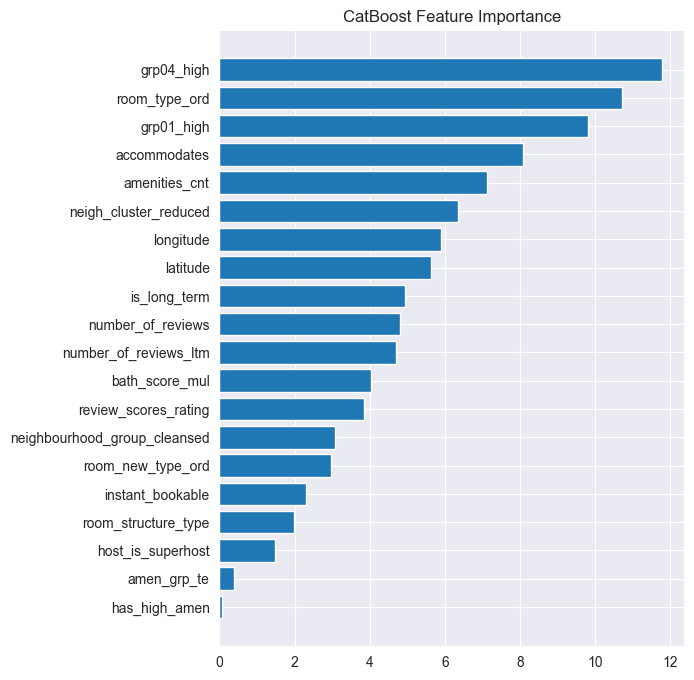

In [61]:
import matplotlib.pyplot as plt

# CatBoost 내장 중요도
fi = model_cb.get_feature_importance(type='FeatureImportance')
fn = model_cb.feature_names_
df_imp = pd.DataFrame({'feature':fn, 'importance':fi}).sort_values('importance', ascending=False)

# 상위 20개 시각화
plt.figure(figsize=(6,8))
plt.barh(df_imp['feature'].head(20)[::-1], df_imp['importance'].head(20)[::-1])
plt.title('CatBoost Feature Importance')
plt.show()


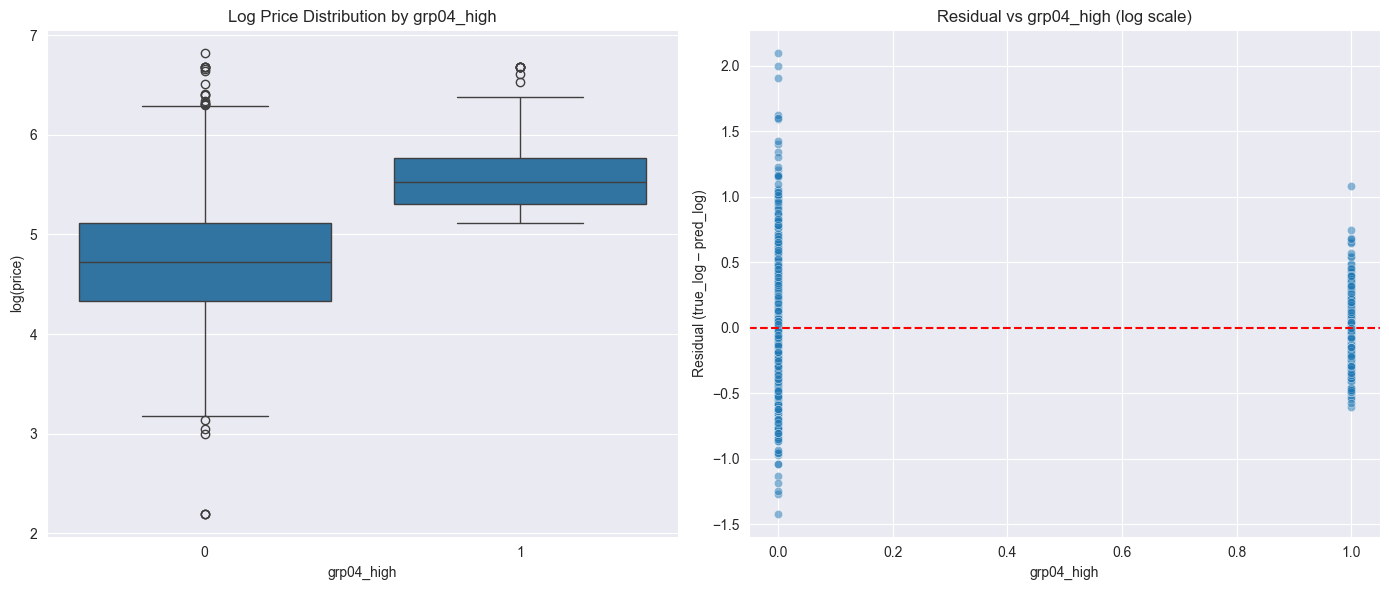

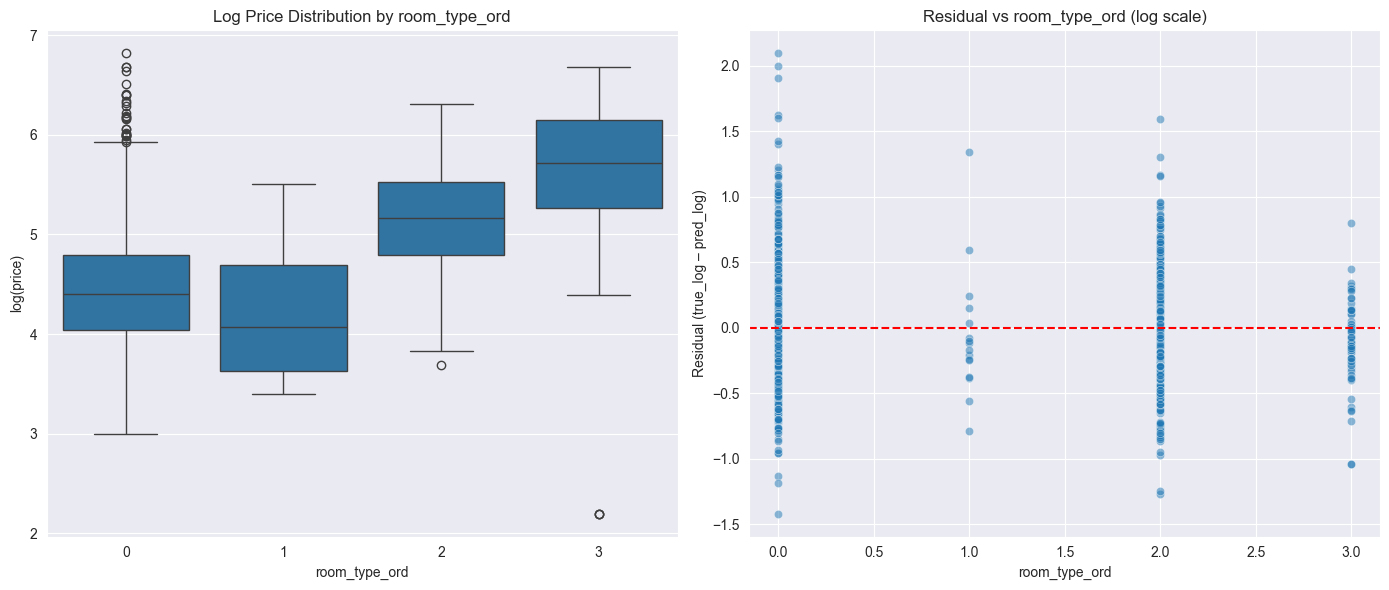

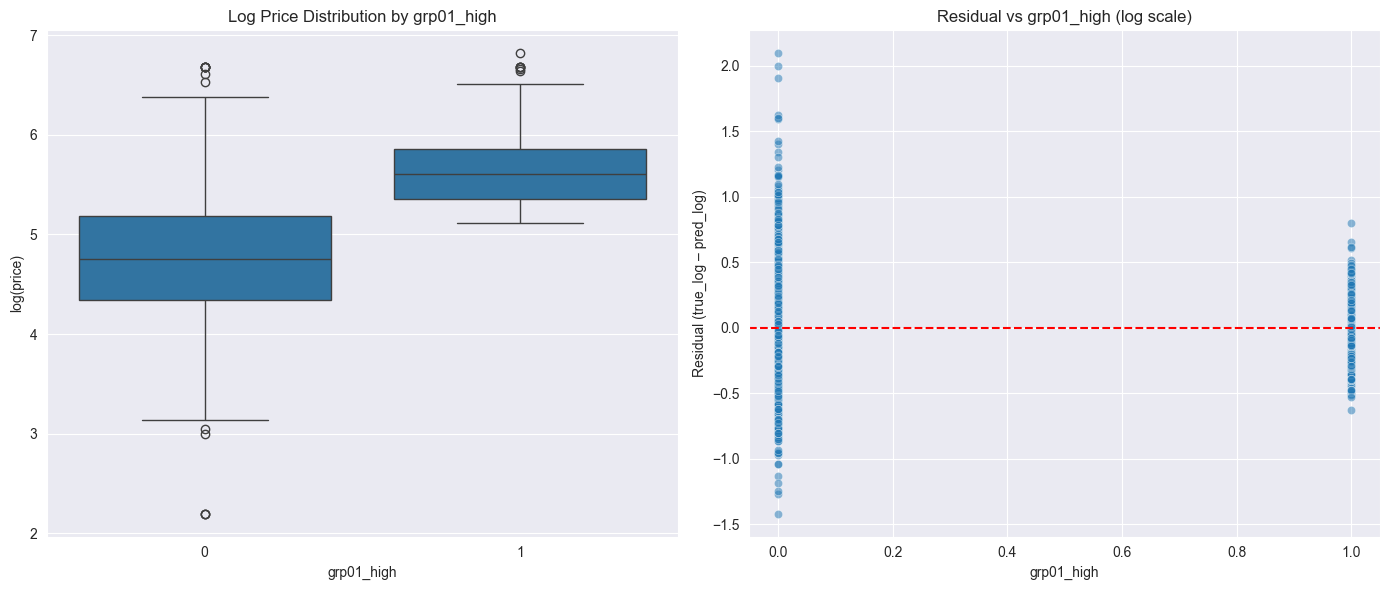

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1) 이미 학습된 model_tuned, 그리고 X_te, y_te가 있다고 가정
#    로그 스케일 예측 및 잔차 계산
pred_log = model_tuned.predict(X_te)
residuals = y_te - pred_log

# 2) 결과를 담을 DataFrame 준비
df_res = X_te.copy()
df_res['true_log']    = y_te
df_res['pred_log']    = pred_log
df_res['residual']    = residuals
df_res['true_price']  = np.expm1(df_res['true_log'])
df_res['pred_price']  = np.expm1(df_res['pred_log'])
df_res['residual_$']  = df_res['true_price'] - df_res['pred_price']

# 3) 최상위 변수들
top_feats = ['grp04_high', 'room_type_ord', 'grp01_high']

# 4) 각 피처별 분포 & 잔차 플롯
for feat in top_feats:
    plt.figure(figsize=(14,6))

    # (a) 피처별 log(price) 분포
    plt.subplot(1, 2, 1)
    sns.boxplot(x=feat, y='true_log', data=df_res)
    plt.title(f'Log Price Distribution by {feat}')
    plt.xlabel(feat)
    plt.ylabel('log(price)')

    # (b) 피처별 잔차 산점도
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=feat, y='residual', data=df_res, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual vs {feat} (log scale)')
    plt.xlabel(feat)
    plt.ylabel('Residual (true_log – pred_log)')

    plt.tight_layout()
    plt.show()


In [51]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import pandas as pd
from scipy import stats

# ──────────────────────────────────────────────
# 0) 데이터 준비
# ──────────────────────────────────────────────
features_final = [
    'grp04_high', 'room_type_ord', 'grp01_high',
    # … + 나머지 최종 피처들
]
X = df[features_final]
y = df['log_price']

# ──────────────────────────────────────────────
# 1) grp04_high 효과 검정 (t-test)
# ──────────────────────────────────────────────
grp0 = df.loc[df['grp04_high']==0, 'log_price']
grp1 = df.loc[df['grp04_high']==1, 'log_price']
tstat, pval = stats.ttest_ind(grp1, grp0, equal_var=False)
print(f"grp04_high t-stat: {tstat:.2f}, p-value: {pval:.3f}")
# → p-value가 작으면 grp04_high가 유의미

# ──────────────────────────────────────────────
# 2) 모델과 cat_features 지정
# ──────────────────────────────────────────────
cat_feats = ['grp04_high', 'room_type_ord', 'grp01_high']  # 문자열 칼럼 이름
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=False,
    cat_features=cat_feats       # ← 꼭 지정!
)

# ──────────────────────────────────────────────
# 3) 기본 CV RMSE
# ──────────────────────────────────────────────
scores_base = -cross_val_score(
    model, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
print(f"Base CV RMSE: {scores_base.mean():.3f}")

# ──────────────────────────────────────────────
# 4) 교호작용 추가 후 CV
# ──────────────────────────────────────────────
df['int_grp04_room'] = df['grp04_high'] * df['room_type_ord']
X2 = df[features_final + ['int_grp04_room']]
cat_feats2 = cat_feats + ['int_grp04_room']

model2 = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=False,
    cat_features=cat_feats2
)
scores_int = -cross_val_score(
    model2, X2, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
print(f"+Interaction CV RMSE: {scores_int.mean():.3f}")

# ──────────────────────────────────────────────
# 5) grp04_high 제거 후 CV
# ──────────────────────────────────────────────
feats_drop = [f for f in features_final if f!='grp04_high']
X3 = df[feats_drop]
# cat_features 에서도 제거
cat_feats3 = [c for c in cat_feats if c!='grp04_high']

model3 = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=False,
    cat_features=cat_feats3
)
scores_drop = -cross_val_score(
    model3, X3, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
print(f"- grp04_high CV RMSE: {scores_drop.mean():.3f}")


grp04_high t-stat: 110.09, p-value: 0.000
Base CV RMSE: 0.411


KeyboardInterrupt: 

In [28]:
import joblib
import numpy as np
import pandas as pd
from scipy import stats
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

# 0) Optuna 스터디에서 최적 파라미터 불러오기 & 키 매핑
study = joblib.load('optuna_study.pkl')
best_params = study.best_params.copy()
if 'lr' in best_params:
    best_params['learning_rate'] = best_params.pop('lr')
if 'l2' in best_params:
    best_params['l2_leaf_reg']   = best_params.pop('l2')
if 'bt' in best_params:
    best_params['bagging_temperature'] = best_params.pop('bt')

# 1) 피처 리스트 재정의 (실제 사용 중인 그대로)
cat_cols = [
    'neigh_cluster_reduced',
    'neighbourhood_group_cleansed',
    'room_type_ord',
    'room_new_type_ord',
    'room_structure_type',
]
num_cols = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm',
]
bin_cols = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_high_amen','has_Wifi','has_Air_conditioning',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator',
]
te_cols = ['amen_grp_te']
features_final = cat_cols + num_cols + bin_cols + te_cols + ['grp01_high','grp04_high']

# 2) X, y 준비
X = df[features_final]
y = df['log_price']

# 3) grp04_high t-검정 (확인용)
tstat, pval = stats.ttest_ind(
    df.loc[df['grp04_high']==1, 'log_price'],
    df.loc[df['grp04_high']==0, 'log_price'],
    equal_var=False
)
print(f"grp04_high t-stat: {tstat:.2f}, p-value: {pval:.3f}")

# 4) CatBoost 모델 정의 (모든 문자열 칼럼 포함)
cat_feats = cat_cols + ['grp01_high','grp04_high']
model_base = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=False,
    cat_features=cat_feats
)

# 5) Base CV RMSE
scores_base = -cross_val_score(
    model_base, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
print(f"Tuned Base CV RMSE (log): {scores_base.mean():.3f}")

# 6) Interaction 추가 실험
df['int_grp04_room'] = df['grp04_high'] * df['room_type_ord']
X_int = df[features_final + ['int_grp04_room']]
cat_feats_int = cat_feats + ['int_grp04_room']
model_int = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=False,
    cat_features=cat_feats_int
)
scores_int = -cross_val_score(
    model_int, X_int, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
print(f"+Interaction CV RMSE (log): {scores_int.mean():.3f}")

# 7) grp04_high 제거 실험
feats_drop = [f for f in features_final if f!='grp04_high']
X_drop = df[feats_drop]
cat_feats_drop = [c for c in cat_feats if c!='grp04_high']
model_drop = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=False,
    cat_features=cat_feats_drop
)
scores_drop = -cross_val_score(
    model_drop, X_drop, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
print(f"-grp04_high CV RMSE (log): {scores_drop.mean():.3f}")



grp04_high t-stat: 110.09, p-value: 0.000
Tuned Base CV RMSE (log): 0.311
+Interaction CV RMSE (log): 0.312
-grp04_high CV RMSE (log): 0.342


In [ ]:
print(f"Tuned Base CV RMSE (log): 0.311")

# 6) Interaction 추가 실험
df['int_grp04_room'] = df['grp04_high'] * df['room_type_ord']
X_int = df[features_final + ['int_grp04_room']]
cat_feats_int = cat_feats + ['int_grp04_room']
model_int = CatBoostRegressor(
    **best_params,
    random_state=42,
    verbose=False,
    cat_features=cat_feats_int
)
scores_int = -cross_val_score(
    model_int, X_int, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1
)
print(f"+Interaction CV RMSE (log): {scores_int.mean():.3f}")

In [33]:
from itertools import combinations
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# 1) 상위 N개 변수 선택
top_feats = [
    'grp04_high',
    'room_type_ord',
    'accommodates',
    'amenities_cnt'
]

results = []

# 2) Optuna에서 구한 best_params & 네이밍 매핑 (이전 그대로)
study = joblib.load('optuna_study.pkl')
best_params = study.best_params.copy()
if 'lr' in best_params:        best_params['learning_rate'] = best_params.pop('lr')
if 'l2' in best_params:       best_params['l2_leaf_reg']   = best_params.pop('l2')
if 'bt' in best_params:       best_params['bagging_temperature'] = best_params.pop('bt')

# 3) 베이스 모델 CV RMSE
X_base = df[features_final]
y = df['log_price']
model_base = CatBoostRegressor(**best_params,
                              random_state=42, verbose=False,
                              cat_features=cat_cols + ['grp01_high','grp04_high'])
base_rmse = -cross_val_score(model_base, X_base, y,
                             scoring='neg_root_mean_squared_error',
                             cv=5, n_jobs=-1).mean()

# 4) 각 조합마다 interaction 추가 후 CV RMSE 계산
for f1, f2 in combinations(top_feats, 2):
    col_int = f'{f1}_x_{f2}'
    df[col_int] = df[f1] * df[f2]

    X_int = df[features_final + [col_int]]
    cat_feats_int = cat_cols + ['grp01_high','grp04_high']
    if col_int in ['grp04_high_x_room_type_ord','grp01_high_x_room_type_ord']:
        cat_feats_int.append(col_int)  # 범주형 교호작용만 cat_features에 추가

    model_int = CatBoostRegressor(**best_params,
                                  random_state=42, verbose=False,
                                  cat_features=cat_feats_int)
    rmse_int = -cross_val_score(model_int, X_int, y,
                                scoring='neg_root_mean_squared_error',
                                cv=5, n_jobs=-1).mean()

    results.append({
        'interaction': f'{f1}×{f2}',
        'CV_RMSE_log': rmse_int,
        'Δ from base': rmse_int - base_rmse
    })

# 5) 결과 정리
import pandas as pd
df_res = pd.DataFrame(results).sort_values('Δ from base')
print(f"Base CV RMSE (log): {base_rmse:.3f}\n")
print(df_res.to_string(index=False))


KeyboardInterrupt: 

In [62]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 1) 데이터 분할 (80% train / 20% validation)
X = df[features_final]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) Optuna best_params 불러와 키 매핑
import joblib
study = joblib.load('optuna_study.pkl')
best_params = study.best_params.copy()
if 'lr' in best_params: best_params['learning_rate'] = best_params.pop('lr')
if 'l2' in best_params: best_params['l2_leaf_reg']   = best_params.pop('l2')
if 'bt' in best_params: best_params['bagging_temperature'] = best_params.pop('bt')

# 3) 모델 선언: iterations(최대트리), early_stopping_rounds 지정
model_es = CatBoostRegressor(
    **best_params,
    iterations=5000,            # 최대 5,000그루까지 학습
    early_stopping_rounds=100,  # 100번 반복 개선 없으면 중단
    use_best_model=True,        # 검증셋에서 가장 좋았던 시점으로 롤백
    random_seed=42,
    verbose=100,                # 스크린에 100트리마다 로그 출력
    cat_features=cat_cols + ['grp01_high','grp04_high']
)

# 4) 학습 (eval_set에 validation을 지정해야 early stopping이 작동)
model_es.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val)
)

# 5) 검증셋 성능 평가
pred_log = model_es.predict(X_val)
rmse_log = mean_squared_error(y_val, pred_log, squared=False)
mae_log  = mean_absolute_error(  y_val, pred_log)
r2       = r2_score(              y_val, pred_log)

pred_price = np.expm1(pred_log)
true_price = np.expm1(y_val)
rmse_     = mean_squared_error(true_price, pred_price, squared=False)
mae_      = mean_absolute_error(  true_price, pred_price)
mape       = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

print(f"✅ Early-stopping Model Performance:")
print(f" R² (log)   : {r2:.3f}")
print(f" RMSE (log) : {rmse_log:.3f}")
print(f" MAE  (log) : {mae_log:.3f}")
print(f" RMSE ($)   : ${rmse_:,.2f}")
print(f" MAE  ($)   : ${mae_:,.2f}")
print(f" MAPE       : {mape:.1f} %")


0:	learn: 0.6288949	test: 0.6295494	best: 0.6295494 (0)	total: 16.4ms	remaining: 1m 21s
100:	learn: 0.2972413	test: 0.3203788	best: 0.3203788 (100)	total: 1.71s	remaining: 1m 22s
200:	learn: 0.2687031	test: 0.3061983	best: 0.3061983 (200)	total: 3.25s	remaining: 1m 17s
300:	learn: 0.2542063	test: 0.3013893	best: 0.3013893 (300)	total: 4.75s	remaining: 1m 14s
400:	learn: 0.2405350	test: 0.2982926	best: 0.2982926 (400)	total: 6.25s	remaining: 1m 11s
500:	learn: 0.2288249	test: 0.2965611	best: 0.2965611 (500)	total: 7.76s	remaining: 1m 9s
600:	learn: 0.2186608	test: 0.2954020	best: 0.2954020 (600)	total: 9.26s	remaining: 1m 7s
700:	learn: 0.2099056	test: 0.2946529	best: 0.2946529 (700)	total: 10.9s	remaining: 1m 6s
800:	learn: 0.2017515	test: 0.2939639	best: 0.2939433 (797)	total: 12.3s	remaining: 1m 4s
900:	learn: 0.1946284	test: 0.2934401	best: 0.2934401 (900)	total: 13.9s	remaining: 1m 3s
1000:	learn: 0.1885098	test: 0.2932027	best: 0.2932027 (1000)	total: 15.7s	remaining: 1m 2s
1100:	

In [63]:
import joblib
from catboost import CatBoostRegressor

# 1) 모델_es 는 위에서 fit()한 early-stopping 모델
best_iter = model_es.get_best_iteration()
print(f"▶️ 최적 트리 개수: {best_iter}")

# 2) 최적 트리 개수로 final 모델 생성
final_cb = CatBoostRegressor(
    **best_params,
    iterations=best_iter,     # early-stopping에게 결정된 트리 개수
    random_seed=42,
    verbose=False,
    cat_features=cat_cols + ['grp01_high','grp04_high']
)

# 3) 전체 데이터로 재학습
final_cb.fit(X, y)

# 4) 디스크에 저장
joblib.dump(final_cb, 'catboost_final_model_2.cbm')
print("✅ 최종 모델 저장됨 → catboost_final_model_2.cbm")


▶️ 최적 트리 개수: 1594
✅ 최종 모델 저장됨 → catboost_final_model_2.cbm


In [ ]:
# 2) blending 모듈 로드
import blending

# 3) 새로운 데이터 준비 예시
import pandas as pd
new_df = pd.DataFrame([{
    # features_final 리스트에 포함된 칼럼들
    'neigh_cluster_reduced': 'nbr_grp_04',
    'room_new_type_ord': 1,
    'room_type_ord': 0,
    'accommodates': 2,
    'is_long_term': 0,
    'instant_bookable': 1,
    'has_high_amen': 0,
    # … te_cols 필드도 채워 주세요
}], columns=features_final)

# 4) 앙상블 예측
preds = blending.predict_price(new_df)
print(preds)

In [37]:
import time
import json
import pandas as pd
import requests

import geopandas as gpd
from shapely.geometry import Point

# ─────────────────────────────────────────────────────────────────────────────
# 0) 원본 df, poi_tags, 그리고 bbox 계산
  # latitude, longitude 칼럼이 있어야 함

poi_tags = {
    'transport': {
        'amenity': ['bus_station','taxi'],
        'railway': ['station']
    },
    'infrastructure': {
        'amenity': ['police','hospital','pharmacy','restaurant','supermarket']
    },
    'tourism': {
        'tourism': ['viewpoint','museum','attraction'],
        'leisure': ['park']
    }
}

pad = 0.01
minx, maxx = df.longitude.min()-pad, df.longitude.max()+pad
miny, maxy = df.latitude.min()-pad, df.latitude.max()+pad

# ─────────────────────────────────────────────────────────────────────────────
# 1) 한 번에 bbox 내 모든 POI 내려받기 (Overpass bbox 쿼리)
OVERPASS_URL = "http://overpass-api.de/api/interpreter"
# build filters for bbox query
filters = ""
for grp in poi_tags.values():
    for key, vals in grp.items():
        for v in vals:
            filters += f'node["{key}"="{v}"]({miny},{minx},{maxy},{maxx});\n'

# full query
query = f"""
[out:json][timeout:180];
(
{filters}
);
out body;
"""

resp = requests.post(OVERPASS_URL, data={'data': query}, timeout=(5,300))
resp.raise_for_status()
data = resp.json().get('elements', [])

# ─────────────────────────────────────────────────────────────────────────────
# 2) GeoDataFrame 생성
pois = pd.DataFrame([
    {
      'lon': el['lon'],
      'lat': el['lat'],
      **el.get('tags',{})
    }
    for el in data
    if el['type']=='node' and 'lon' in el
])
gdf_pois = gpd.GeoDataFrame(
    pois,
    geometry=gpd.points_from_xy(pois.lon, pois.lat),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# 원본 좌표도 GeoDataFrame
gdf_pts = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=3857)

sindex = gdf_pois.sindex

# ─────────────────────────────────────────────────────────────────────────────
# 3) 그룹별 카운트 함수
def count_group(pt, grp_map, radius=1000):
    buf = pt.buffer(radius)
    candidates = gdf_pois.iloc[list(sindex.intersection(buf.bounds))]
    cnt = 0
    for key, vals in grp_map.items():
        cnt += candidates[candidates[key].isin(vals)].shape[0]
    return cnt

# 4) 각 포인트별 count, df에 붙이기
for grp, tags in poi_tags.items():
    df[f"{grp}_count"] = [
        count_group(pt, tags, radius=1000)
        for pt in gdf_pts.geometry
    ]

# 5) 결과 확인
print(df[['transport_count','infrastructure_count','tourism_count']].head())

   transport_count  infrastructure_count  tourism_count
0                7                    77              1
1                3                    79              4
2                4                    34              2
3                7                   117              1
4               15                   335              3


In [42]:
from sklearn.decomposition import PCA

poi_cols = ['transport_count','infrastructure_count','tourism_count']
pca = PCA(n_components=1)

# PCA fit → PC1 점수 생성
df['poi_pca1'] = pca.fit_transform(df[poi_cols].fillna(0))

# 설명 분산 비율 확인 (얼마나 데이터의 변동성을 담았는지)
print("Explained variance ratio (PC1):", pca.explained_variance_ratio_[0])

#poi_pca1 <0 poi 희박 지역, poi_pca1 > 0 poi 밀집지역

Explained variance ratio (PC1): 0.9982082112260969


In [38]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1) 연속형 점수로 만드는 PCA 방법
pca = PCA(n_components=1, random_state=42)
df['region_score'] = pca.fit_transform(
    df[['transport_count','infrastructure_count','tourism_count']]
).ravel()

# (선택) 0–1 사이로 정규화하고 싶다면
df['region_score_norm'] = (
    df['region_score'] - df['region_score'].min()
) / (df['region_score'].max() - df['region_score'].min())

# 2) 혹은 카테고리형 군집으로 만드는 KMeans 방법
kmeans = KMeans(n_clusters=4, random_state=42)
df['region_cluster'] = kmeans.fit_predict(
    df[['transport_count','infrastructure_count','tourism_count']]
)

# 결과 확인
print(df[['transport_count','infrastructure_count','tourism_count',
          'region_score','region_score_norm','region_cluster']].head())

print("Explained variance ratio (PC1):", pca.explained_variance_ratio_[0])


   transport_count  infrastructure_count  tourism_count  region_score  \
0                7                    77              1    -37.863477   
1                3                    79              4    -35.914362   
2                4                    34              2    -80.892434   
3                7                   117              1      2.094658   
4               15                   335              3    220.203233   

   region_score_norm  region_cluster  
0           0.141007               3  
1           0.144568               3  
2           0.062406               0  
3           0.214000               3  
4           0.612423               1  
Explained variance ratio (PC1): 0.9982082112260983


In [65]:
best_iter = model_es.get_best_iteration()
final_cb = CatBoostRegressor(
    **best_params,
    iterations=best_iter,
    random_seed=42,
    verbose=False,
    cat_features=cat_cols + ['grp01_high','grp04_high']
)
final_cb.fit(X, y)
joblib.dump(final_cb, 'catboost_final_3.cbm')

['catboost_final_3.cbm']

In [79]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 0) 피처 리스트
cat_cols = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type'
]
num_cols = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm'
]
bin_cols = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_high_amen','has_Wifi','has_Air_conditioning',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator'
]
te_cols       = ['amen_grp_te']
other_flags   = ['grp01_high','grp04_high']
features_final= cat_cols + num_cols + bin_cols + te_cols + other_flags

# 1) train/val 분할
X = df[features_final]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) Optuna 파라미터 로드 & 키 매핑
study       = joblib.load('optuna_study.pkl')
best_params = study.best_params.copy()
if 'lr' in best_params:   best_params['learning_rate']     = best_params.pop('lr')
if 'l2' in best_params:   best_params['l2_leaf_reg']       = best_params.pop('l2')
if 'bt' in best_params:   best_params['bagging_temperature']= best_params.pop('bt')

# 3) 공통 전처리: 범주형만 ordinal encoding → HGB에 사용
preprocessor = ColumnTransformer([
    ('ord', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ), cat_cols)
], remainder='passthrough')
# → HGB용 pipeline 에서만 활용

# 4-1) CatBoost pipeline: DataFrame 그대로 주고,
#      cat_features에 이름(list) 지정 → 문자열 그대로 범주 처리
cat_pipeline = Pipeline([
    ('identity', FunctionTransformer(lambda X: X, validate=False)),
    ('cb', CatBoostRegressor(
        **best_params,
        iterations=best_iter,
        random_seed=42,
        verbose=False,
        cat_features=cat_cols + other_flags
    ))
])
# 한 줄 설명: CatBoost는 pandas DataFrame + cat_features(names)로
#                내부에서 안전하게 범주 처리합니다.

# 4-2) HGB pipeline: preprocessor→수치형만 HistGradientBoosting
hgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('hgb', HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_iter=1000,
        early_stopping='auto',
        random_state=42
    ))
])
# 한 줄 설명: HGB는 숫자만 입력 가능하므로, ordinal encoding 후 학습

# 5) Stacking 앙상블: 두 모델 예측 → RidgeCV 로 블렌딩
stack = StackingRegressor(
    estimators=[
        ('cat', cat_pipeline),
        ('hgb', hgb_pipeline)
    ],
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
# 한 줄 설명: 메타 모델에는 두 모델의 예측값만 전달해
#                순수하게 앙상블 성능을 높입니다.

# 6) 학습 & 예측
stack.fit(X_tr, y_tr)
pred_log = stack.predict(X_val)

# 7) 지표 계산
rmse_log = mean_squared_error(y_val, pred_log, squared=False)
mae_log  = mean_absolute_error(y_val, pred_log)
r2       = r2_score(y_val, pred_log)

pred_price = np.expm1(pred_log)
true_price = np.expm1(y_val)
rmse   = mean_squared_error(true_price, pred_price, squared=False)
mae    = mean_absolute_error(true_price, pred_price)
mape   = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

# 8) 결과 출력
print("=== Stacked Ensemble Performance ===")
print(f" R² (log)   : {r2:.3f}")
print(f" RMSE (log) : {rmse_log:.3f}")
print(f" MAE  (log) : {mae_log:.3f}")
print(f" RMSE ($)   : ${rmse:,.2f}")
print(f" MAE  ($)   : ${mae:,.2f}")
print(f" MAPE       : {mape:.1f} %")

=== Stacked Ensemble Performance ===
 R² (log)   : 0.799
 RMSE (log) : 0.288
 MAE  (log) : 0.208
 RMSE ($)   : $48.71
 MAE  ($)   : $31.16
 MAPE       : 21.4 %


In [80]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1) 이진 분류 기준: 실제 가격의 중앙값
true_price = np.expm1(y_val)
pred_price = np.expm1(pred_log)
threshold = np.median(true_price)

# 2) 레이블 생성 (0=저가, 1=고가)
y_true_cls = (true_price > threshold).astype(int)
y_pred_cls = (pred_price > threshold).astype(int)

# 3) 혼동행렬 및 분류 리포트
cm = confusion_matrix(y_true_cls, y_pred_cls)
print("Confusion Matrix:\n", cm)
print(classification_report(y_true_cls, y_pred_cls, target_names=['Low','High']))


Confusion Matrix:
 [[1791  265]
 [ 322 1734]]
              precision    recall  f1-score   support

         Low       0.85      0.87      0.86      2056
        High       0.87      0.84      0.86      2056

    accuracy                           0.86      4112
   macro avg       0.86      0.86      0.86      4112
weighted avg       0.86      0.86      0.86      4112



=== Over/Underfitting Check ===
 Train RMSE (log): 0.170,  R²: 0.930
  Val  RMSE (log): 0.288,  R²: 0.799


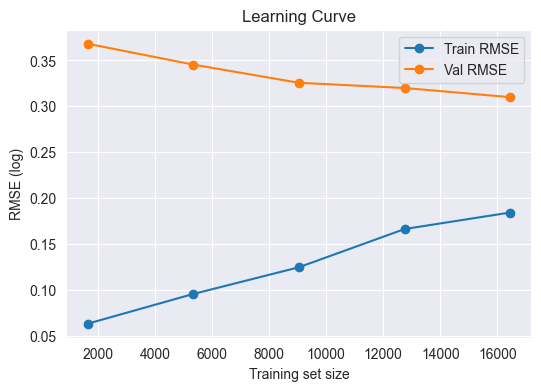

In [81]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# --- 1) 훈련/검증 성능 비교 ---

# 1-1) 훈련 세트 예측
pred_log_tr = stack.predict(X_tr)

# 1-2) 성능 계산 함수
def calc_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return rmse, r2

rmse_tr, r2_tr = calc_metrics(y_tr, pred_log_tr)
rmse_val, r2_val = calc_metrics(y_val, pred_log)

print("=== Over/Underfitting Check ===")
print(f" Train RMSE (log): {rmse_tr:.3f},  R²: {r2_tr:.3f}")
print(f"  Val  RMSE (log): {rmse_val:.3f},  R²: {r2_val:.3f}")

# → Train 성능이 훨씬 좋으면 과적합, 둘 다 낮으면 과소적합 의심

# --- 2) 학습 곡선(learning curve) 시각화 (선택) ---

# 전체 데이터(X, y)를 사용해 학습 곡선을 그리면 학습 양에 따른 편차를 확인할 수 있습니다.
train_sizes, train_scores, val_scores = learning_curve(
    stack,                                   # 학습할 모델
    X,                                       # 전체 피처
    y,                                       # 전체 타깃
    cv=5,                                    # 5-폴드 교차검증
    scoring='neg_root_mean_squared_error',   # RMSE
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# 음수가 나온 점수를 양수 RMSE로 변환
train_rmse = -train_scores.mean(axis=1)
val_rmse   = -val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, val_rmse,   marker='o', label='Val RMSE')
plt.xlabel('Training set size')
plt.ylabel('RMSE (log)')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


                         feature  importance
0                  has_high_amen    0.076998
1                    amen_grp_te    0.398827
2              host_is_superhost    1.483210
3            room_structure_type    1.976477
4               instant_bookable    2.298415
5              room_new_type_ord    2.972215
6   neighbourhood_group_cleansed    3.086723
7           review_scores_rating    3.846688
8                 bath_score_mul    4.022370
9          number_of_reviews_ltm    4.710278
10             number_of_reviews    4.815483
11                  is_long_term    4.938388
12                      latitude    5.631258
13                     longitude    5.894132
14         neigh_cluster_reduced    6.355999
15                 amenities_cnt    7.116120
16                  accommodates    8.079675
17                    grp01_high    9.813701
18                 room_type_ord   10.702493
19                    grp04_high   11.780550


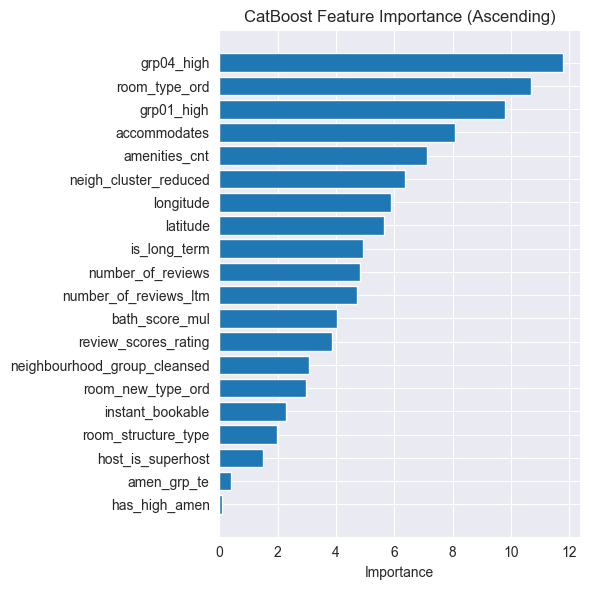

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# 기존 df_imp가 feature·importance 컬럼을 가지는 DataFrame이라고 가정

# 1) 중요도 오름차순 정렬
df_imp_sorted = df_imp.sort_values('importance', ascending=True).reset_index(drop=True)

# 2) 정렬된 테이블 출력
print(df_imp_sorted[['feature', 'importance']])

# 3) 시각화 (낮은 중요도 → 높은 중요도 순)
plt.figure(figsize=(6, 0.3 * len(df_imp_sorted)))
plt.barh(df_imp_sorted['feature'], df_imp_sorted['importance'])
plt.title('CatBoost Feature Importance (Ascending)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [105]:
cat_model = stack.named_estimators_['cat'].named_steps['cb']
print("CatBoost가 본 피처 개수:", len(cat_model.feature_names_))

CatBoost가 본 피처 개수: 25


In [117]:
# 1) CatBoost 모델 객체 가져오기
cat_model = stack.named_estimators_['cat'].named_steps['cb']

# 2) 피처 이름·중요도 새로 추출
fn = cat_model.feature_names_
fi = cat_model.get_feature_importance(type='FeatureImportance')

# 3) DataFrame 재생성
import pandas as pd
df_imp = pd.DataFrame({'feature': fn, 'importance': fi})

# 4) 개수 확인
print("총 피처 개수:", df_imp.shape[0])   # → 25로 나와야 합니다.

# 5) 오름차순 정렬해 보기
df_imp_sorted = df_imp.sort_values('importance', ascending=True).reset_index(drop=True)
print(df_imp_sorted)


총 피처 개수: 25
                         feature  importance
0                       has_Wifi    0.349017
1                       amen_grp    0.646380
2                   has_Elevator    0.678129
3      has_Carbon_monoxide_alarm    0.809608
4                    has_Bathtub    1.092714
5              host_is_superhost    1.174298
6           has_Air_conditioning    1.313107
7               instant_bookable    1.765948
8            room_structure_type    1.781922
9              room_new_type_ord    2.435735
10  neighbourhood_group_cleansed    2.598595
11          review_scores_rating    3.629728
12                bath_score_mul    3.784043
13                  is_long_term    4.186670
14         number_of_reviews_ltm    4.512055
15             number_of_reviews    5.002381
16                      latitude    5.010091
17             region_score_norm    5.286570
18         neigh_cluster_reduced    5.344888
19                     longitude    5.478214
20                 amenities_cnt    7.09221

In [139]:
cat_cols = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type', 'amen_grp'
]
num_cols = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm'
]
bin_cols = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_Air_conditioning', 'has_Wifi',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator'
]
other_flags   = ['grp01_high','grp04_high']
features_new = cat_cols + num_cols + bin_cols + other_flags

In [140]:
# 최종 선택 모델

cat_cols = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type', 'amen_grp'
]
num_cols = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm'
]
bin_cols = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_Air_conditioning', 'has_Wifi',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator'
]
other_flags   = ['grp01_high','grp04_high']
features_new = cat_cols + num_cols + bin_cols + other_flags

# 1) train/val 분할
X = df[features_new]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) Optuna 파라미터 로드 & 키 매핑
study       = joblib.load('optuna_study.pkl')
best_params = study.best_params.copy()
if 'lr' in best_params:   best_params['learning_rate']     = best_params.pop('lr')
if 'l2' in best_params:   best_params['l2_leaf_reg']       = best_params.pop('l2')
if 'bt' in best_params:   best_params['bagging_temperature']= best_params.pop('bt')

# 3) 공통 전처리: 범주형만 ordinal encoding → HGB에 사용
preprocessor = ColumnTransformer([
    ('ord', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ), cat_cols)
], remainder='passthrough')
# → HGB용 pipeline 에서만 활용

# 4-1) CatBoost pipeline: DataFrame 그대로 주고,
#      cat_features에 이름(list) 지정 → 문자열 그대로 범주 처리
cat_pipeline = Pipeline([
    ('identity', FunctionTransformer(lambda X: X, validate=False)),
    ('cb', CatBoostRegressor(
        **best_params,
        iterations=best_iter,
        random_seed=42,
        verbose=False,
        cat_features=cat_cols + other_flags
    ))
])
# 한 줄 설명: CatBoost는 pandas DataFrame + cat_features(names)로
#                내부에서 안전하게 범주 처리합니다.

# 4-2) HGB pipeline: preprocessor→수치형만 HistGradientBoosting
hgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('hgb', HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_iter=1000,
        early_stopping='auto',
        random_state=42
    ))
])
# 한 줄 설명: HGB는 숫자만 입력 가능하므로, ordinal encoding 후 학습

# 5) Stacking 앙상블: 두 모델 예측 → RidgeCV 로 블렌딩
stack = StackingRegressor(
    estimators=[
        ('cat', cat_pipeline),
        ('hgb', hgb_pipeline)
    ],
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
# 한 줄 설명: 메타 모델에는 두 모델의 예측값만 전달해
#                순수하게 앙상블 성능을 높입니다.

# 6) 학습 & 예측
stack.fit(X_tr, y_tr)
pred_log = stack.predict(X_val)

# 7) 지표 계산
rmse_log = mean_squared_error(y_val, pred_log, squared=False)
mae_log  = mean_absolute_error(y_val, pred_log)
r2       = r2_score(y_val, pred_log)

pred_price = np.expm1(pred_log)
true_price = np.expm1(y_val)
rmse   = mean_squared_error(true_price, pred_price, squared=False)
mae    = mean_absolute_error(true_price, pred_price)
mape   = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

# 8) 결과 출력
print("=== Stacked Ensemble Performance ===")
print(f" R² (log)   : {r2:.3f}")
print(f" RMSE (log) : {rmse_log:.3f}")
print(f" MAE  (log) : {mae_log:.3f}")
print(f" RMSE ($)   : ${rmse:,.2f}")
print(f" MAE  ($)   : ${mae:,.2f}")
print(f" MAPE       : {mape:.1f} %")

=== Stacked Ensemble Performance ===
 R² (log)   : 0.799
 RMSE (log) : 0.288
 MAE  (log) : 0.208
 RMSE ($)   : $48.57
 MAE  ($)   : $31.16
 MAPE       : 21.4 %


In [116]:
# 1-1) 훈련 세트 예측
pred_log_tr = stack.predict(X_tr)

# 1-2) 성능 계산 함수
def calc_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return rmse, r2

rmse_tr, r2_tr = calc_metrics(y_tr, pred_log_tr)
rmse_val, r2_val = calc_metrics(y_val, pred_log)

print("=== Over/Underfitting Check ===")
print(f" Train RMSE (log): {rmse_tr:.3f},  R²: {r2_tr:.3f}")
print(f"  Val  RMSE (log): {rmse_val:.3f},  R²: {r2_val:.3f}")

=== Over/Underfitting Check ===
 Train RMSE (log): 0.173,  R²: 0.927
  Val  RMSE (log): 0.288,  R²: 0.799


In [127]:
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# 0) 피처 리스트
cat_cols = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type', 'amen_grp'
]
num_cols = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm'
]
bin_cols = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_Air_conditioning', 'has_Wifi',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator'
]
other_flags = ['grp01_high','grp04_high']
features    = cat_cols + num_cols + bin_cols + other_flags

# 1) train/validation 분할
X = df[features]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.4,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) Optuna 결과 로드 & 키 매핑
study       = joblib.load('optuna_study.pkl')
best_params = study.best_params.copy()
if 'lr' in best_params:    best_params['learning_rate']      = best_params.pop('lr')
if 'l2' in best_params:    best_params['l2_leaf_reg']        = best_params.pop('l2')
if 'bt' in best_params:    best_params['bagging_temperature'] = best_params.pop('bt')

# 3) CatBoost용 파라미터 정리
best_params.pop('depth', None)  # 혹시 남아있는 경우 제거
best_params.update({
    'iterations': 2000,
    'depth': 8,           # 나무 깊이 제한 ↓
    'l2_leaf_reg': 10     # L2 규제 강화
})

# 4) CatBoost 모델 학습 (단순화 + 조기 종료)
model_cb = CatBoostRegressor(
    **best_params,
    cat_features=cat_cols + other_flags,
    random_seed=42,
    verbose=False
)
model_cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100
)

# 5) HGB 모델 학습 (리프 제한 + 조기 종료)
preprocessor = ColumnTransformer([
    ('ord', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ), cat_cols)
], remainder='passthrough')

model_hgb = Pipeline([
    ('pre', preprocessor),
    ('hgb', HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_leaf_nodes=50,      # 리프 노드 수 제한 ↓
        validation_fraction=0.1,
        n_iter_no_change=50,    # 조기 종료
        random_state=42
    ))
])
model_hgb.fit(X_tr, y_tr)

# 6) Stacking 앙상블 재훈련
stack = StackingRegressor(
    estimators=[
        ('cat', model_cb),
        ('hgb', model_hgb)
    ],
    final_estimator=RidgeCV(),
    cv=5, n_jobs=-1, passthrough=False
)
stack.fit(X_tr, y_tr)

# 7) 검증 성능 평가
pred_log     = stack.predict(X_val)
rmse_log     = mean_squared_error(y_val, pred_log, squared=False)
mae_log      = mean_absolute_error(y_val, pred_log)
r2           = r2_score(y_val, pred_log)
pred_price   = np.expm1(pred_log)
true_price   = np.expm1(y_val)
rmse_dollar  = mean_squared_error(true_price, pred_price, squared=False)
mae_dollar   = mean_absolute_error(true_price, pred_price)
mape         = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

print("=== Simplified + Early Stopping Ensemble ===")
print(f"R² (log):   {r2:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"MAE  (log): {mae_log:.3f}")
print(f"RMSE ($):   ${rmse_dollar:,.2f}")
print(f"MAE  ($):   ${mae_dollar:,.2f}")
print(f"MAPE:       {mape:.1f} %")

# 한 줄 요약:
# depth, l2_leaf_reg, max_leaf_nodes로 모델을 단순화하고, early_stopping_rounds·n_iter_no_change로 학습을 조기 종료해 과적합을 완화합니다.


=== Simplified + Early Stopping Ensemble ===
R² (log):   0.787
RMSE (log): 0.295
MAE  (log): 0.221
RMSE ($):   $51.49
MAE  ($):   $33.88
MAPE:       22.7 %


In [128]:
# 1-1) 훈련 세트 예측
pred_log_tr = stack.predict(X_tr)

# 1-2) 성능 계산 함수
def calc_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return rmse, r2

rmse_tr, r2_tr = calc_metrics(y_tr, pred_log_tr)
rmse_val, r2_val = calc_metrics(y_val, pred_log)

print("=== Over/Underfitting Check ===")
print(f" Train RMSE (log): {rmse_tr:.3f},  R²: {r2_tr:.3f}")
print(f"  Val  RMSE (log): {rmse_val:.3f},  R²: {r2_val:.3f}")

=== Over/Underfitting Check ===
 Train RMSE (log): 0.243,  R²: 0.858
  Val  RMSE (log): 0.295,  R²: 0.787


In [134]:
import joblib
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 0) Feature lists
cat_cols    = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type','amen_grp'
]
num_cols    = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm'
]
bin_cols    = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_Wifi','has_Air_conditioning','has_Bathtub',
    'has_Carbon_monoxide_alarm','has_Elevator'
]
other_flags = ['grp01_high','grp04_high']
features    = cat_cols + num_cols + bin_cols + other_flags

# 1) train/validation split
X = df[features]; y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) load Optuna study & map params
study       = joblib.load('optuna_study.pkl')
best_params = study.best_params.copy()
if 'lr' in best_params:   best_params['learning_rate']     = best_params.pop('lr')
if 'l2' in best_params:   best_params['l2_leaf_reg']       = best_params.pop('l2')
if 'bt' in best_params:   best_params['bagging_temperature']= best_params.pop('bt')

# 3) update for simplification + early stopping
best_params.pop('depth', None)
best_params.update({
    'iterations': 2000,
    'depth':       8,
    'l2_leaf_reg': 10
})

# 4) CatBoost (cat_features in constructor avoids float-conversion errors)
model_cb = CatBoostRegressor(
    **best_params,
    cat_features=cat_cols + other_flags,
    random_seed=42,
    verbose=False
)
model_cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100
)

# 5) HGB pipeline (ordinal encoding + early stopping)
hgb_pipeline = Pipeline([
    ('encode', ColumnTransformer([
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ], remainder='passthrough')),
    ('model', HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_leaf_nodes=50,
        validation_fraction=0.1,
        n_iter_no_change=50,
        random_state=42
    ))
])
hgb_pipeline.fit(X_tr, y_tr)

# 6) stacking ensemble
stack = StackingRegressor(
    estimators=[('cat', model_cb), ('hgb', hgb_pipeline)],
    final_estimator=RidgeCV(),
    cv=5, n_jobs=-1, passthrough=False
)
stack.fit(X_tr, y_tr)

# 7) validation metrics
pred_log    = stack.predict(X_val)
rmse_log    = mean_squared_error(y_val, pred_log, squared=False)
mae_log     = mean_absolute_error(y_val, pred_log)
r2          = r2_score(y_val, pred_log)
pred_price  = np.expm1(pred_log)
true_price  = np.expm1(y_val)
rmse_dollar = mean_squared_error(true_price, pred_price, squared=False)
mae_dollar  = mean_absolute_error(true_price, pred_price)
mape        = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

print("=== Final Ensemble Performance ===")
print(f"R² (log):   {r2:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"MAE  (log): {mae_log:.3f}")
print(f"RMSE ($):   ${rmse_dollar:,.2f}")
print(f"MAE  ($):   ${mae_dollar:,.2f}")
print(f"MAPE:       {mape:.1f} %")

'''# 8) optional 5-fold CV RMSE(log)
cv_scores = cross_val_score(
    stack, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
print(f"CV RMSE (log): {-cv_scores.mean():.3f} ± {cv_scores.std():.3f}")'''

# 한 줄 요약:
# depth=8, l2_leaf_reg=10, max_leaf_nodes=50로 모델을 단순화하고,
# early_stopping_rounds=100·n_iter_no_change=50로 학습을 조기 종료해 과적합을 완화하며,
# CatBoost에 cat_features를 생성자에 지정해 문자열 → float 오류를 해결했습니다.

=== Final Ensemble Performance ===
R² (log):   0.791
RMSE (log): 0.293
MAE  (log): 0.216
RMSE ($):   $49.88
MAE  ($):   $32.41
MAPE:       22.2 %


'# 8) optional 5-fold CV RMSE(log)\ncv_scores = cross_val_score(\n    stack, X, y,\n    cv=5,\n    scoring=\'neg_root_mean_squared_error\',\n    n_jobs=-1\n)\nprint(f"CV RMSE (log): {-cv_scores.mean():.3f} ± {cv_scores.std():.3f}")'

In [135]:
# 1-1) 훈련 세트 예측
pred_log_tr = stack.predict(X_tr)

# 1-2) 성능 계산 함수
def calc_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    return rmse, r2

rmse_tr, r2_tr = calc_metrics(y_tr, pred_log_tr)
rmse_val, r2_val = calc_metrics(y_val, pred_log)

print("=== Over/Underfitting Check ===")
print(f" Train RMSE (log): {rmse_tr:.3f},  R²: {r2_tr:.3f}")
print(f"  Val  RMSE (log): {rmse_val:.3f},  R²: {r2_val:.3f}")

=== Over/Underfitting Check ===
 Train RMSE (log): 0.247,  R²: 0.852
  Val  RMSE (log): 0.293,  R²: 0.791


In [138]:
import pandas as pd

# 1) 스태킹 모델에서 CatBoost 서브모델 꺼내기
cat_model = stack.named_estimators_['cat']

# 2) 피처 이름과 중요도 추출
features = cat_model.feature_names_
importances = cat_model.get_feature_importance(type='FeatureImportance')

# 3) DataFrame 생성 후 내림차순 정렬
df_imp = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

# 4) 콘솔에 전체 출력 (엑셀에 복붙 가능)
print(df_imp.to_string(index=False))



                     feature  importance
                  grp04_high   15.612400
               room_type_ord   14.450844
                  grp01_high   13.686341
                accommodates    8.225069
                is_long_term    6.065641
               amenities_cnt    5.444908
       neigh_cluster_reduced    4.526756
       number_of_reviews_ltm    4.109075
                   longitude    3.564746
           region_score_norm    3.511942
              bath_score_mul    3.133974
           number_of_reviews    3.043846
                    latitude    2.801713
        review_scores_rating    2.346540
           room_new_type_ord    1.978205
            instant_bookable    1.483958
neighbourhood_group_cleansed    1.476591
         room_structure_type    1.180798
           host_is_superhost    0.749086
        has_Air_conditioning    0.610290
   has_Carbon_monoxide_alarm    0.609192
                has_Elevator    0.435563
                 has_Bathtub    0.403398
                

In [143]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

# 0) feature lists, X, y 정의는 이전과 동일

# 1) Optuna study with MedianPruner
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
)

def objective(trial):
    # CatBoost params (iterations down to 200–500)
    cb_params = {
        'iterations': trial.suggest_int('cb_iter', 200, 500),
        'learning_rate': trial.suggest_float('cb_lr', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('cb_depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('cb_l2', 0.1, 20.0, log=True),
        'bagging_temperature': trial.suggest_float('cb_bt', 0.0, 1.0),
        'random_seed': 42,
        'verbose': False
    }
    cb = CatBoostRegressor(**cb_params, cat_features=cat_cols+other_flags)

    # HGB params
    pre = ColumnTransformer(
        [('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)],
        remainder='passthrough'
    )
    hgb = HistGradientBoostingRegressor(
        learning_rate=trial.suggest_float('hgb_lr', 1e-3, 0.1, log=True),
        max_leaf_nodes=trial.suggest_int('hgb_leaves', 20, 80),
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42
    )
    hgb_pipe = Pipeline([('pre', pre), ('hgb', hgb)])

    # Stacking with 3-fold CV
    stack = StackingRegressor(
        estimators=[('cat', cb), ('hgb', hgb_pipe)],
        final_estimator=RidgeCV(),
        cv=3,               # ↓ folds from 5→3
        n_jobs=-1,
        passthrough=False
    )

    scores = cross_val_score(
        stack, X, y,
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    trial.report(-scores.mean(), step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return -scores.mean()

# 2) run optimization with fewer trials
study.optimize(objective, n_trials=20)
print("Best params:", study.best_params)
print("Best CV RMSE:", study.best_value)


[I 2025-07-22 15:34:30,186] A new study created in memory with name: no-name-21cd7679-b77c-495f-a98b-9aaeb054f235
[I 2025-07-22 15:34:45,998] Trial 0 finished with value: 0.3078653891811867 and parameters: {'cb_iter': 488, 'cb_lr': 0.02121576067926868, 'cb_depth': 5, 'cb_l2': 3.035887880173563, 'cb_bt': 0.549062768707492, 'hgb_lr': 0.033425405054573885, 'hgb_leaves': 48}. Best is trial 0 with value: 0.3078653891811867.
[I 2025-07-22 15:35:07,109] Trial 1 finished with value: 0.3120946054320086 and parameters: {'cb_iter': 233, 'cb_lr': 0.02135029328295102, 'cb_depth': 8, 'cb_l2': 1.2790985913631798, 'cb_bt': 0.49966800563778424, 'hgb_lr': 0.0028542665182221968, 'hgb_leaves': 47}. Best is trial 0 with value: 0.3078653891811867.
[I 2025-07-22 15:36:13,558] Trial 2 finished with value: 0.304755759176394 and parameters: {'cb_iter': 467, 'cb_lr': 0.013019049022568108, 'cb_depth': 9, 'cb_l2': 0.7249340937719309, 'cb_bt': 0.7679417266408319, 'hgb_lr': 0.01362953222496533, 'hgb_leaves': 64}. Be

Best params: {'cb_iter': 307, 'cb_lr': 0.08027664266442806, 'cb_depth': 10, 'cb_l2': 0.1283336308467712, 'cb_bt': 0.002525606419472276, 'hgb_lr': 0.0014923811758666369, 'hgb_leaves': 80}
Best CV RMSE: 0.29174846425407974


In [198]:
import joblib
import numpy as np
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 0) feature lists
cat_cols    = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type','amen_grp',
    'description_length_group', 'name_length_group' # 새로 추가
]
num_cols    = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm',
    'host_response_time_score', 'host_response_rate_score'
]
bin_cols    = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_Air_conditioning','has_Wifi',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator',
    'neighborhood_overview_exists'                                      # 새로 추가
]
other_flags = ['grp01_high','grp04_high']
features    = cat_cols + num_cols + bin_cols + other_flags

# 1) 데이터 분할
X = df[features]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) Optuna 스터디 로드
study = joblib.load('optuna_study.pkl')
best  = study.best_params.copy()

# 3) 파라미터 매핑
# CatBoost
cb_iter = best.get('cb_iter', best.get('iterations', 1000))
cb_lr   = best.get('cb_lr',   best.get('lr',        0.05))
cb_depth= best.get('cb_depth',best.get('depth',     6))
cb_l2   = best.get('cb_l2',   best.get('l2',        3.0))
cb_bt   = best.get('cb_bt',   best.get('bt',        1.0))

cb_params = {
    'iterations':         cb_iter,
    'learning_rate':      cb_lr,
    'depth':              cb_depth,
    'l2_leaf_reg':        cb_l2,
    'bagging_temperature':cb_bt,
    'random_seed':        42,
    'verbose':            False
}

# HGB
hgb_lr     = best.get('hgb_lr',     0.05)
hgb_leaves = best.get('hgb_leaves', 31)

hgb_params = {
    'learning_rate':      hgb_lr,
    'max_leaf_nodes':     hgb_leaves,
    'validation_fraction':0.1,
    'n_iter_no_change':   50,
    'random_state':       42
}

# 4) CatBoost 학습 (cat_features 명시)
model_cb = CatBoostRegressor(**cb_params, cat_features=cat_cols+other_flags)
model_cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100
)

# 5) HGB 파이프라인
pre = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
], remainder='passthrough')

model_hgb = Pipeline([
    ('pre', pre),
    ('hgb', HistGradientBoostingRegressor(**hgb_params))
])
model_hgb.fit(X_tr, y_tr)

# 6) Stacking 앙상블
stack = StackingRegressor(
    estimators=[('cat', model_cb), ('hgb', model_hgb)],
    final_estimator=RidgeCV(),
    cv=5, n_jobs=-1, passthrough=False
)
stack.fit(X_tr, y_tr)

# 7) 검증 지표 계산
pred_log    = stack.predict(X_val)
rmse_log    = mean_squared_error(y_val, pred_log, squared=False)
mae_log     = mean_absolute_error(y_val, pred_log)
r2          = r2_score(y_val, pred_log)
pred_price  = np.expm1(pred_log)
true_price  = np.expm1(y_val)
rmse_usd    = mean_squared_error(true_price, pred_price, squared=False)
mae_usd     = mean_absolute_error(true_price, pred_price)
mape        = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

print("=== Final Ensemble Performance ===")
print(f"R² (log)   : {r2:.3f}")
print(f"RMSE (log) : {rmse_log:.3f}")
print(f"MAE  (log) : {mae_log:.3f}")
print(f"RMSE ($)   : ${rmse_usd:,.2f}")
print(f"MAE  ($)   : ${mae_usd:,.2f}")
print(f"MAPE       : {mape:.1f} %")

# 8) 모델 저장
joblib.dump(stack, 'final_ensemble_model_2.pkl')
print("Model saved to final_ensemble_model_2.pkl")


KeyboardInterrupt: 

In [15]:
import joblib
import numpy as np
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 0) feature lists
cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type', 'amen_grp',
    'description_length_group', 'name_length_group'  # 새로 추가
]
num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm', 'region_score_norm',
    'host_response_time_score', 'host_response_rate_score'  # 새로 추가
]
bin_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_Air_conditioning', 'has_Wifi',
    'has_Bathtub', 'has_Carbon_monoxide_alarm', 'has_Elevator',
    'neighborhood_overview_exists'  # 새로 추가
]
other_flags = ['grp01_high', 'grp04_high']
features = cat_cols + num_cols + bin_cols + other_flags

# 1) 데이터 분할
X = df[features]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) Optuna 스터디 로드
study = joblib.load('optuna_study.pkl')
best = study.best_params.copy()

# 3) 파라미터 매핑
# CatBoost
cb_iter = best.get('cb_iter', best.get('iterations', 1000))
cb_lr = best.get('cb_lr', best.get('lr', 0.05))
cb_depth = best.get('cb_depth', best.get('depth', 6))
cb_l2 = best.get('cb_l2', best.get('l2', 3.0))
cb_bt = best.get('cb_bt', best.get('bt', 1.0))

cb_params = {
    'iterations': cb_iter,
    'learning_rate': cb_lr,
    'depth': cb_depth,
    'l2_leaf_reg': cb_l2,
    'bagging_temperature': cb_bt,
    'random_seed': 42,
    'verbose': False
}

# HGB
hgb_lr = best.get('hgb_lr', 0.05)
hgb_leaves = best.get('hgb_leaves', 31)

hgb_params = {
    'learning_rate': hgb_lr,
    'max_leaf_nodes': hgb_leaves,
    'validation_fraction': 0.1,
    'n_iter_no_change': 50,
    'random_state': 42
}

# 4) CatBoost 학습 (cat_features 명시)
model_cb = CatBoostRegressor(**cb_params, cat_features=cat_cols + other_flags)
model_cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100
)

# 5) HGB 파이프라인
pre = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
], remainder='passthrough')

model_hgb = Pipeline([
    ('pre', pre),
    ('hgb', HistGradientBoostingRegressor(**hgb_params))
])
model_hgb.fit(X_tr, y_tr)

# 6) Stacking 앙상블
stack = StackingRegressor(
    estimators=[('cat', model_cb), ('hgb', model_hgb)],
    final_estimator=RidgeCV(),
    cv=5, n_jobs=-1, passthrough=False
)
stack.fit(X_tr, y_tr)

# 7) 검증 지표 계산
pred_log = stack.predict(X_val)
rmse_log = mean_squared_error(y_val, pred_log, squared=False)
mae_log = mean_absolute_error(y_val, pred_log)
r2 = r2_score(y_val, pred_log)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_val)
rmse_usd = mean_squared_error(true_price, pred_price, squared=False)
mae_usd = mean_absolute_error(true_price, pred_price)
mape = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

print("=== Final Ensemble Performance ===")
print(f"R² (log)   : {r2:.3f}")
print(f"RMSE (log) : {rmse_log:.3f}")
print(f"MAE  (log) : {mae_log:.3f}")
print(f"RMSE ($)   : ${rmse_usd:,.2f}")
print(f"MAE  ($)   : ${mae_usd:,.2f}")
print(f"MAPE       : {mape:.1f} %")

# 8) 모델 저장
joblib.dump(stack, 'final_ensemble_model_4.pkl')
print("Model saved to final_ensemble_model_4.pkl")


=== Final Ensemble Performance ===
R² (log)   : 0.981
RMSE (log) : 0.115
MAE  (log) : 0.060
RMSE ($)   : $38.55
MAE  ($)   : $16.96
MAPE       : 6.0 %
Model saved to final_ensemble_model_3.pkl


In [18]:
print(f"Total samples in df: {df.shape[0]} rows")
df = df.drop_duplicates(subset=['latitude','longitude'], keep='first')
# 3) 제거 후 행 개수 확인
print("After dedup: ", df.shape[0])

Total samples in df: 430756 rows
After dedup:  18597


In [16]:
# 1) 데이터 분할 & 사이즈 출력
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)
print(f"Train samples: {X_tr.shape[0]},  Validation samples: {X_val.shape[0]}")

# ... (모델 학습 코드 그대로)

# 6) Stacking 앙상블 학습
stack.fit(X_tr, y_tr)

# 7) Train 지표 계산
pred_tr_log = stack.predict(X_tr)
rmse_tr_log = mean_squared_error(y_tr, pred_tr_log, squared=False)
r2_tr       = r2_score(y_tr, pred_tr_log)

# 8) Validation 지표 계산
pred_val_log = stack.predict(X_val)
rmse_val_log = mean_squared_error(y_val, pred_val_log, squared=False)
r2_val       = r2_score(y_val, pred_val_log)

# 9) 지표 출력
print("=== Model Performance ===")
print(f" Train → RMSE(log): {rmse_tr_log:.3f},  R²: {r2_tr:.3f}")
print(f"  Val  → RMSE(log): {rmse_val_log:.3f},  R²: {r2_val:.3f}")


Train samples: 344604,  Validation samples: 86152


KeyboardInterrupt: 

In [10]:
import joblib
import numpy as np
import pandas as pd

# 0) 피처 리스트 (훈련 때와 동일)
cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type', 'amen_grp',
    'description_length_group', 'name_length_group'  # 새로 추가
]
num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm', 'region_score_norm',
    'host_response_time_score', 'host_response_rate_score'      # 새로 추가
]
other_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_Air_conditioning', 'has_Wifi',
    'has_Bathtub', 'has_Carbon_monoxide_alarm', 'has_Elevator',
    'neighborhood_overview_exists', 'grp01_high', 'grp04_high'  # 새로 추가
]

# 1) 원본 y_log 준비 & split
y_log = pd.to_numeric(df['log_price'], errors='coerce')
_, X_val, _, y_val_log = train_test_split(
    df[features], y_log,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)
mask = y_val_log.notna()
X_val       = X_val.loc[mask].copy()
y_val_log   = y_val_log.loc[mask].astype(float)

# 2) 깨끗하게 전처리
# 수치형 → float, NaN→0
X_val[num_cols] = (
    X_val[num_cols]
      .apply(pd.to_numeric, errors='coerce')
      .fillna(0)
      .astype(float)
)

# 범주형 → str, NaN→"missing"
for c in cat_cols + other_cols:
    X_val[c] = X_val[c].astype(str).fillna("missing")

# 3) 모델 로드 & 예측
model = joblib.load('final_ensemble_model_2.pkl')
pred_log   = model.predict(X_val)
pred_price = np.expm1(pred_log)

# 4) 실제값 배열
y_true_log   = y_val_log.values
y_true_price = np.expm1(y_true_log)

# 5) 지표 계산
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error
)

r2       = r2_score(y_true_log,   pred_log)
rmse_log = mean_squared_error(y_true_log,   pred_log,   squared=False)
mae_log  = mean_absolute_error(y_true_log,   pred_log)

rmse_usd = mean_squared_error(y_true_price, pred_price, squared=False)
mae_usd  = mean_absolute_error(y_true_price, pred_price)
mape     = np.mean(np.abs((y_true_price - pred_price) / y_true_price)) * 100

# 6) 결과 출력
print("=== final_ensemble_model_2 Performance ===")
print(f"R² (log)   : {r2:.3f}")
print(f"RMSE (log) : {rmse_log:.3f}")
print(f"MAE  (log) : {mae_log:.3f}")
print(f"RMSE ($)   : ${rmse_usd:,.2f}")
print(f"MAE  ($)   : ${mae_usd:,.2f}")
print(f"MAPE       : {mape:.1f} %")


=== final_ensemble_model_2 Performance ===
R² (log)   : 0.921
RMSE (log) : 0.234
MAE  (log) : 0.184
RMSE ($)   : $79.21
MAE  ($)   : $48.89
MAPE       : 19.8 %


In [13]:
from sklearn.model_selection import train_test_split

# 1) 원본 데이터를 동일하게 분할
X = df[features]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) 학습 샘플 개수 출력
print(f"훈련 샘플 개수: {X_tr.shape[0]}개")
print(f"검증 샘플 개수: {X_val.shape[0]}개")


훈련 샘플 개수: 344604개
검증 샘플 개수: 86152개


In [14]:
model = joblib.load('final_ensemble_model_2.pkl')

# 3) 예측 (로그 & 달러)
pred_tr_log = model.predict(X_tr).astype(float)
pred_val_log= model.predict(X_val).astype(float)

pred_tr_usd = np.expm1(pred_tr_log)
pred_val_usd= np.expm1(pred_val_log)

# 4) 지표 계산 함수
def log_metrics(y_true, y_pred):
    return {
        'R2'  : r2_score(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred, squared=False),
        'MAE' : mean_absolute_error(y_true, y_pred)
    }

def usd_metrics(y_true_log, y_pred_usd):
    y_true_usd = np.expm1(y_true_log)
    return {
        'RMSE($)': mean_squared_error(y_true_usd, y_pred_usd, squared=False),
        'MAE($)' : mean_absolute_error(y_true_usd, y_pred_usd),
        'MAPE(%)': np.mean(np.abs((y_true_usd - y_pred_usd)/y_true_usd)) * 100
    }

# 5) Train 지표
train_log = log_metrics(y_tr_log, pred_tr_log)
train_usd = usd_metrics(y_tr_log, pred_tr_usd)

# 6) Validation 지표
val_log   = log_metrics(y_val_log, pred_val_log)
val_usd   = usd_metrics(y_val_log, pred_val_usd)

# 7) 결과 출력
print("=== Train Performance ===")
print(f"R² (log)   : {train_log['R2']:.3f}")
print(f"RMSE (log) : {train_log['RMSE']:.3f}")
print(f"MAE  (log) : {train_log['MAE']:.3f}")
print(f"RMSE ($)   : ${train_usd['RMSE($)']:.2f}")
print(f"MAE  ($)   : ${train_usd['MAE($)']:.2f}")
print(f"MAPE       : {train_usd['MAPE(%)']:.1f} %\n")

print("=== Validation Performance ===")
print(f"R² (log)   : {val_log['R2']:.3f}")
print(f"RMSE (log) : {val_log['RMSE']:.3f}")
print(f"MAE  (log) : {val_log['MAE']:.3f}")
print(f"RMSE ($)   : ${val_usd['RMSE($)']:.2f}")
print(f"MAE  ($)   : ${val_usd['MAE($)']:.2f}")
print(f"MAPE       : {val_usd['MAPE(%)']:.1f} %")

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [9]:
import joblib

study = joblib.load('optuna_study.pkl')
print("=== Optuna Best CV (로그 RMSE) ===")
print(f"{study.best_value:.3f}")


=== Optuna Best CV (로그 RMSE) ===
0.289


/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/hye_project/for_machine_learning_2.csv')

In [193]:
import joblib
import numpy as np
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 0) feature lists
cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type', 'amen_grp',
    'description_length_group', 'name_length_group'  # 새로 추가
]
num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm', 'region_score_norm',
    'host_response_time_score', 'host_response_rate_score',
    'availability_365'# 새로 추가
]
bin_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_Air_conditioning', 'has_Wifi',
    'has_Bathtub', 'has_Carbon_monoxide_alarm', 'has_Elevator',
    'neighborhood_overview_exists'  # 새로 추가
]
other_flags = ['grp01_high', 'grp04_high']
features = cat_cols + num_cols + bin_cols + other_flags

# 1) 데이터 분할
X = df[features]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)

# 2) Optuna 스터디 로드
study = joblib.load('optuna_study.pkl')
best = study.best_params.copy()

# 3) 파라미터 매핑
# CatBoost
cb_iter = best.get('cb_iter', best.get('iterations', 1000))
cb_lr = best.get('cb_lr', best.get('lr', 0.05))
cb_depth = best.get('cb_depth', best.get('depth', 6))
cb_l2 = best.get('cb_l2', best.get('l2', 3.0))
cb_bt = best.get('cb_bt', best.get('bt', 1.0))

cb_params = {
    'iterations': cb_iter,
    'learning_rate': cb_lr,
    'depth': cb_depth,
    'l2_leaf_reg': cb_l2,
    'bagging_temperature': cb_bt,
    'random_seed': 42,
    'verbose': False
}

# HGB
hgb_lr = best.get('hgb_lr', 0.05)
hgb_leaves = best.get('hgb_leaves', 31)

hgb_params = {
    'learning_rate': hgb_lr,
    'max_leaf_nodes': hgb_leaves,
    'validation_fraction': 0.1,
    'n_iter_no_change': 50,
    'random_state': 42
}

# 4) CatBoost 학습 (cat_features 명시)
model_cb = CatBoostRegressor(**cb_params, cat_features=cat_cols + other_flags)
model_cb.fit(
    X_tr, y_tr,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100
)

# 5) HGB 파이프라인
pre = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
], remainder='passthrough')

model_hgb = Pipeline([
    ('pre', pre),
    ('hgb', HistGradientBoostingRegressor(**hgb_params))
])
model_hgb.fit(X_tr, y_tr)

# 6) Stacking 앙상블
stack = StackingRegressor(
    estimators=[('cat', model_cb), ('hgb', model_hgb)],
    final_estimator=RidgeCV(),
    cv=5, n_jobs=-1, passthrough=False
)
stack.fit(X_tr, y_tr)

# 7) 검증 지표 계산
pred_log = stack.predict(X_val)
rmse_log = mean_squared_error(y_val, pred_log, squared=False)
mae_log = mean_absolute_error(y_val, pred_log)
r2 = r2_score(y_val, pred_log)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_val)
rmse_usd = mean_squared_error(true_price, pred_price, squared=False)
mae_usd = mean_absolute_error(true_price, pred_price)
mape = np.mean(np.abs((true_price - pred_price) / true_price)) * 100

print("=== Final Ensemble Performance ===")
print(f"R² (log)   : {r2:.3f}")
print(f"RMSE (log) : {rmse_log:.3f}")
print(f"MAE  (log) : {mae_log:.3f}")
print(f"RMSE ($)   : ${rmse_usd:,.2f}")
print(f"MAE  ($)   : ${mae_usd:,.2f}")
print(f"MAPE       : {mape:.1f} %")

# 8) 모델 저장
joblib.dump(stack, 'final_ensemble_model_3.pkl')
print("Model saved to final_ensemble_model_3.pkl")


KeyboardInterrupt: 

In [2]:
df_2 = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/Airbnb_project_15/entire_remove_outlier.csv')

# 1) df_2에서 추가할 컬럼 리스트
new_cols = [
    'description_length_group',
    'name_length_group',
    'host_response_time_score',
    'host_response_rate_score',
    'neighborhood_overview_exists'
]

# 2) latitude, longitude 포함한 서브셋 생성
df2_subset = df_2[['latitude', 'longitude'] + new_cols]

# 3) df에 left merge
df = df.merge(
    df2_subset,
    on=['latitude', 'longitude'],
    how='left'
)

# 4) merge 결과 확인 (null이 아닌지)
print(df[new_cols].isna().sum())


NameError: name 'df' is not defined

Index(['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'availability_60', 'availability_365',
       'instant_bookable',
       ...
       'grp04_high_x_amenities_cnt', 'room_type_ord_x_grp01_high',
       'room_type_ord_x_accommodates', 'transport_count',
       'infrastructure_count', 'tourism_count', 'poi_pca1', 'region_score',
       'region_score_norm', 'region_cluster'],
      dtype='object', length=103)

In [180]:
import optuna
import numpy as np
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# 0) 피처 리스트
cat_cols    = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type','amen_grp'
]
num_cols    = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm'
]
bin_cols    = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_Air_conditioning','has_Wifi',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator'
]
other_flags = ['grp01_high','grp04_high']
features    = cat_cols + num_cols + bin_cols + other_flags

# 1) 데이터 준비
X = df[features]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=df['room_type_ord'], random_state=42
)

# 2) Optuna objective
def objective(trial):
    # 2-1) CatBoost 하이퍼파라미터
    cb_params = {
        'iterations': trial.suggest_int('cb_iter', 500, 1000),
        'learning_rate': trial.suggest_float('cb_lr', 1e-3, 0.2, log=True),
        'depth': trial.suggest_int('cb_depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('cb_l2', 0.1, 20.0, log=True),
        'bagging_temperature': trial.suggest_float('cb_bt', 0.0, 1.0),
        'random_seed': 42,
        'verbose': False
    }
    cb = CatBoostRegressor(**cb_params, cat_features=cat_cols+other_flags)

    # 2-2) HGB 하이퍼파라미터
    hgb_params = {
        'learning_rate': trial.suggest_float('hgb_lr', 1e-3, 0.2, log=True),
        'max_leaf_nodes': trial.suggest_int('hgb_leaves', 20, 100),
        'validation_fraction': 0.1,
        'n_iter_no_change': 50,
        'random_state': 42
    }
    pre = ColumnTransformer([
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ], remainder='passthrough')
    hgb = HistGradientBoostingRegressor(**hgb_params)
    hgb_pipe = Pipeline([('pre', pre), ('hgb', hgb)])

    # 2-3) Stacking 모델
    stack = StackingRegressor(
        estimators=[('cat', cb), ('hgb', hgb_pipe)],
        final_estimator=RidgeCV(),
        cv=5, n_jobs=-1, passthrough=False
    )

    # 2-4) 5-폴드 CV RMSE(log) 계산
    scores = cross_val_score(
        stack, X, y,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    return -scores.mean()

# 3) 스터디 실행
study_2 = optuna.create_study(direction='minimize')
study_2.optimize(objective, n_trials=50)

print("Best params:", study_2.best_params)
print("Best CV RMSE(log):", study_2.best_value)


[I 2025-07-22 19:36:05,806] A new study created in memory with name: no-name-85d4190b-0546-4e92-8080-d1421f40528f
[W 2025-07-22 19:36:12,166] Trial 0 failed with parameters: {'cb_iter': 729, 'cb_lr': 0.001592997288036503, 'cb_depth': 4, 'cb_l2': 11.232556828940366, 'cb_bt': 0.44161945270819725, 'hgb_lr': 0.03348876098317669, 'hgb_leaves': 44} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/y0/671x56056fg565s3792l4vnr0000gn/T/ipykernel_69897/434519190.py", line 73, in objective
    scores = cross_val_score(
             ^^^^^^^^^^^^^^^^
  File "/Users/hyeom/PycharmProjects/statistics_2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
    

KeyboardInterrupt: 

In [175]:
df_2 = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/Airbnb_project_15/entire_remove_outlier.csv')

In [178]:
# 1) 위도·경도 반올림해서 키 생성
df['lat_r']    = df['latitude'].round(6)
df['lon_r']    = df['longitude'].round(6)
df_2['lat_r']  = df_2['latitude'].round(6)
df_2['lon_r']  = df_2['longitude'].round(6)

cat_cols    = [
    'neigh_cluster_reduced','neighbourhood_group_cleansed',
    'room_type_ord','room_new_type_ord','room_structure_type','amen_grp'
]
num_cols    = [
    'latitude','longitude','accommodates','bath_score_mul',
    'amenities_cnt','review_scores_rating',
    'number_of_reviews','number_of_reviews_ltm','region_score_norm'
]
bin_cols    = [
    'instant_bookable','is_long_term','host_is_superhost',
    'has_Air_conditioning','has_Wifi',
    'has_Bathtub','has_Carbon_monoxide_alarm','has_Elevator'
]
other_flags = ['grp01_high','grp04_high']
features    = cat_cols + num_cols + bin_cols + other_flags

# 2) merge 할 컬럼 리스트
merge_cols = cat_cols + num_cols + bin_cols + other_flags

# 3) df_2에 merge
df_2 = df_2.merge(
    df[['lat_r','lon_r'] + merge_cols],
    on=['lat_r','lon_r'],
    how='left'
)

# 4) 불필요한 컬럼 제거₩
df_2 = df_2.drop(columns=['lat_r','lon_r'])

KeyboardInterrupt: 

count    432952.000000
mean        154.419936
std         960.328830
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       96960.000000
Name: est_monthly_revenue, dtype: float64


KeyError: "['room_structure_type'] not in index"

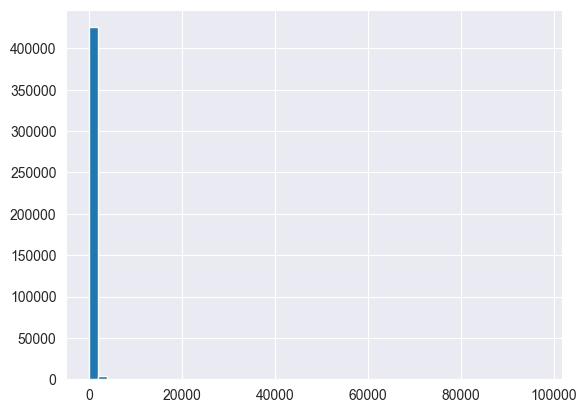

In [177]:
# 1) Estimated Monthly Revenue 계산
df_2['est_monthly_revenue'] = (
    df_2['number_of_reviews_l30d']     # 월별 리뷰 수
    * 2                         # 리뷰당 평균 숙박 회수 (논문 가정)
    * df_2['price']         # 1박 요금
    * df_2['minimum_nights']      # 최소 숙박일
)

# 2) 분포 살펴보기
print(df_2['est_monthly_revenue'].describe())
df_2['est_monthly_revenue'].hist(bins=50)

# 3) 모델 학습 예시 (회귀)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# 피처/타깃 정의
features_rev = features  # 기존 피처 그대로 사용
X = df_2[features_rev]
y = df_2['est_monthly_revenue']

# train/test 분할
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 간단한 회귀 모델
model_rev = HistGradientBoostingRegressor(random_state=42)
model_rev.fit(X_tr, y_tr)

# 검증
pred = model_rev.predict(X_val)
print("MAE:", mean_absolute_error(y_val, pred))


In [201]:
from pprint import pprint

# 1) 전체 파이프라인 파라미터
print("StackingRegressor parameters:")
pprint(stack.get_params())

# 2) 하위 추정기(named_estimators_) 확인
print("\nNamed estimators:")
for name, est in stack.named_estimators_.items():
    print(f"--- {name} ---")
    # CatBoost, HGB pipeline 등 각 모델 파라미터
    pprint(est.get_params())

StackingRegressor parameters:
{'cat': <catboost.core.CatBoostRegressor object at 0x153949e90>,
 'cat__bagging_temperature': 0.6927170960283114,
 'cat__cat_features': ['neigh_cluster_reduced',
                       'neighbourhood_group_cleansed',
                       'room_type_ord',
                       'room_new_type_ord',
                       'room_structure_type',
                       'amen_grp',
                       'description_length_group',
                       'name_length_group',
                       'grp01_high',
                       'grp04_high'],
 'cat__depth': 10,
 'cat__iterations': 1000,
 'cat__l2_leaf_reg': 0.19606413550385973,
 'cat__learning_rate': 0.029638157326550202,
 'cat__loss_function': 'RMSE',
 'cat__random_seed': 42,
 'cat__verbose': False,
 'cv': 5,
 'estimators': [('cat',
                 <catboost.core.CatBoostRegressor object at 0x153949e90>),
                ('hgb',
                 Pipeline(steps=[('pre',
                 ColumnTransform

In [202]:
from pprint import pprint

# 1) 전체 스태킹 파이프라인 파라미터 출력
print("=== StackingRegressor parameters ===")
pprint(stack.get_params())

# 2) named_estimators_ 로 하위 모델별 파라미터 확인
print("\n=== Named estimators ===")
for name, estimator in stack.named_estimators_.items():
    print(f"\n-- {name} --")
    pprint(estimator.get_params())


=== StackingRegressor parameters ===
{'cat': <catboost.core.CatBoostRegressor object at 0x153949e90>,
 'cat__bagging_temperature': 0.6927170960283114,
 'cat__cat_features': ['neigh_cluster_reduced',
                       'neighbourhood_group_cleansed',
                       'room_type_ord',
                       'room_new_type_ord',
                       'room_structure_type',
                       'amen_grp',
                       'description_length_group',
                       'name_length_group',
                       'grp01_high',
                       'grp04_high'],
 'cat__depth': 10,
 'cat__iterations': 1000,
 'cat__l2_leaf_reg': 0.19606413550385973,
 'cat__learning_rate': 0.029638157326550202,
 'cat__loss_function': 'RMSE',
 'cat__random_seed': 42,
 'cat__verbose': False,
 'cv': 5,
 'estimators': [('cat',
                 <catboost.core.CatBoostRegressor object at 0x153949e90>),
                ('hgb',
                 Pipeline(steps=[('pre',
                 ColumnTr

In [204]:
from pprint import pprint

# 1) 전체 스태킹 파이프라인 파라미터 출력
print("=== StackingRegressor parameters ===")
pprint(stack.get_params())

# 2) named_estimators_ 로 하위 모델별 파라미터 확인
print("\n=== Named estimators ===")
for name, estimator in stack.named_estimators_.items():
    print(f"\n-- {name} --")
    pprint(estimator.get_params())


=== StackingRegressor parameters ===
{'cat': <catboost.core.CatBoostRegressor object at 0x153949e90>,
 'cat__bagging_temperature': 0.6927170960283114,
 'cat__cat_features': ['neigh_cluster_reduced',
                       'neighbourhood_group_cleansed',
                       'room_type_ord',
                       'room_new_type_ord',
                       'room_structure_type',
                       'amen_grp',
                       'description_length_group',
                       'name_length_group',
                       'grp01_high',
                       'grp04_high'],
 'cat__depth': 10,
 'cat__iterations': 1000,
 'cat__l2_leaf_reg': 0.19606413550385973,
 'cat__learning_rate': 0.029638157326550202,
 'cat__loss_function': 'RMSE',
 'cat__random_seed': 42,
 'cat__verbose': False,
 'cv': 5,
 'estimators': [('cat',
                 <catboost.core.CatBoostRegressor object at 0x153949e90>),
                ('hgb',
                 Pipeline(steps=[('pre',
                 ColumnTr

In [205]:
import joblib

# 1) Optuna 스터디 로드
study = joblib.load('optuna_study.pkl')

# 2) 맵핑 전 원본 best_params 출력
print("=== Original best_params ===")
print(study.best_params)

# 3) (기존 코드) best_params 복사 후 파라미터 매핑
best = study.best_params.copy()

cb_iter  = best.get('cb_iter', best.get('iterations', 1000))
cb_lr    = best.get('cb_lr', best.get('lr', 0.05))
cb_depth = best.get('cb_depth', best.get('depth', 6))
cb_l2    = best.get('cb_l2', best.get('l2', 3.0))
cb_bt    = best.get('cb_bt', best.get('bt', 1.0))
# … 이하 생략 …


=== Original best_params ===
{'lr': 0.029638157326550202, 'depth': 10, 'l2': 0.19606413550385973, 'bt': 0.6927170960283114}


In [206]:
# 모든 트라이얼 로그 테이블로 보기
df_trials = study.trials_dataframe(attrs=(
    'number', 'value', 'params', 'state'
))
print(df_trials.sort_values('value'))  # 낮은 loss(또는 높은 score) 순으로 정렬


    number     value  params_bt  params_depth  params_l2  params_lr     state
33      33  0.288559   0.692717            10   0.196064   0.029638  COMPLETE
41      41  0.288653   0.572791             9   0.146182   0.035786  COMPLETE
45      45  0.288719   0.477458             9   0.137207   0.039435  COMPLETE
44      44  0.288849   0.487929             9   0.139430   0.039758  COMPLETE
43      43  0.288866   0.500051             9   0.140590   0.041089  COMPLETE
36      36  0.289252   0.584933             9   0.101715   0.034130  COMPLETE
47      47  0.289267   0.479375             9   0.209808   0.041998  COMPLETE
37      37  0.289301   0.516332             9   0.100025   0.036118  COMPLETE
46      46  0.289373   0.390033             8   0.262785   0.059243  COMPLETE
42      42  0.289404   0.715461             9   0.146454   0.051617  COMPLETE
31      31  0.289511   0.840505            10   0.160198   0.023485  COMPLETE
34      34  0.289605   0.576634             9   0.191538   0.032

In [207]:
for idx in sorted(Out):
    print(f"=== Out[{idx}] ===")
    print(Out[idx])
    print("\n")

=== Out[3] ===
      id neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
0  36121       Prospect Heights                     Brooklyn  40.673760   
1  36647            East Harlem                    Manhattan  40.792454   
2  38833                 Harlem                    Manhattan  40.818058   

   longitude  price  estimated_occupancy_l365d  estimated_revenue_l365d  \
0 -73.966110  200.0                          0                      0.0   
1 -73.940742   82.0                          0                      0.0   
2 -73.946671  139.0                        255                  35445.0   

   availability_60  availability_365  ...  amen_grp  amen_grp_te  \
0               57               362  ...      high     4.878113   
1                0               204  ...      high     4.878113   
2               18                25  ...      high     4.878113   

   amen_grp_ord room_new_type_ord  neigh_cluster_reduced has_high_amen  \
0             5                 1   

In [208]:
with open('all_outputs_today.txt', 'w', encoding='utf-8') as f:
    for idx in sorted(Out):
        f.write(f"=== Out[{idx}] ===\n{Out[idx]}\n\n")
print("all_outputs_today.txt 에 저장되었습니다")

all_outputs_today.txt 에 저장되었습니다


In [212]:
import nbformat

# 1) 분석할 노트북 파일 경로 지정
notebook_path = "Catboost.ipynb"  # 실제 .ipynb 파일명으로 변경하세요

# 2) 노트북 읽기
nb = nbformat.read(notebook_path, as_version=4)

# 3) 셀별 출력(Out) 추출 및 출력
for i, cell in enumerate(nb.cells):
    outputs = cell.get('outputs', [])
    if outputs:
        print(f"=== Cell[{i}] outputs ===")
        for out in outputs:
            # 텍스트 출력인 경우
            if 'text' in out:
                print(out['text'])
            # 데이터 형태 등 딕셔너리 출력
            elif 'data' in out and 'text/plain' in out['data']:
                print(out['data']['text/plain'])
        print("\n")


=== Cell[1] outputs ===
      neighbourhood_cleansed neighbourhood_group_cleansed   latitude  \
id                                                                     
36121       Prospect Heights                     Brooklyn  40.673760   
36647            East Harlem                    Manhattan  40.792454   
38833                 Harlem                    Manhattan  40.818058   

       longitude  price  estimated_occupancy_l365d  estimated_revenue_l365d  \
id                                                                            
36121 -73.966110  200.0                          0                      0.0   
36647 -73.940742   82.0                          0                      0.0   
38833 -73.946671  139.0                        255                  35445.0   

       availability_60  availability_365  instant_bookable  ...  amen_grp  \
id                                                          ...             
36121               57               362                 0  ...  

In [19]:
df = pd.read_csv('/Users/hyeom/Documents/GitHub/advanced_project/hye_project/for_machine_learning.csv')

In [32]:
# 1) 주요 식별자 컬럼 정의
keys = ['latitude','longitude','price','amenities_cnt','host_id']

# 2) 인덱스 리셋 (0…20559)
df1r = df1.reset_index(drop=True)
df2r = df2.reset_index(drop=True)

# 3) 두 df의 keys 컬럼이 완전히 일치하는지 확인
match = (df1r[keys] == df2r[keys]).all(axis=None)
print("Are all key columns row-by-row identical?", match)

# 4) 불일치가 있는 행만 골라서 보여보기
if not match:
    diff_idx = ~(df1r[keys] == df2r[keys]).all(axis=1)
    print("Mismatched rows in key columns:")
    print(df1r.loc[diff_idx, keys].join(df2r.loc[diff_idx, keys], lsuffix='_df1', rsuffix='_df2').head())

Are all key columns row-by-row identical? True


In [43]:
import pandas as pd

import pandas as pd

df1 = df_merged
df2 = df

# 1) 붙일 컬럼 리스트
new_cols = [
    'transport_count',
    'infrastructure_count',
    'tourism_count',
    'region_score',
    'region_score_norm',
    'region_cluster'
]

# 2) df1, df2 모두 id가 컬럼에 있는지 확인
assert 'id' in df1.columns, "df1에 'id' 컬럼이 없습니다"
assert 'id' in df2.columns, "df2에 'id' 컬럼이 없습니다"

# 3) 인덱스로 id 설정
df1_idx = df1.set_index('id')
df2_idx = df2.set_index('id')

# 4) df2에서 붙일 컬럼만 추출
df2_subset = df2_idx[new_cols]

# 5) 인덱스 기준으로 concat (df1 기준 left merge 개념)
df_merged = pd.concat([df1_idx, df2_subset], axis=1)

# 6) (선택) 인덱스를 다시 컬럼으로 돌리기
df_merged = df_merged.reset_index()

# 7) 결과 확인
print(f"Merged rows:    {df_merged.shape[0]}  (기대: 20560)")
print(f"Merged columns: {df_merged.shape[1]}")

# 8) CSV로 저장
df_merged.to_csv(
    '/Users/hyeom/Documents/GitHub/advanced_project/hye_project/03_MachineLearning/for_machine_learning_2.csv',
    index=False
)



Merged rows:    20560  (기대: 20560)
Merged columns: 101


In [45]:
df = pd.read_csv('/hye_project/for_machine_learning_2.csv')

In [ ]:
cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type', 'amen_grp',
    'description_length_group', 'name_length_group'  # 새로 추가
]
num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm', 'region_score_norm',
    'host_response_time_score', 'host_response_rate_score'      # 새로 추가
]
other_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_Air_conditioning', 'has_Wifi',
    'has_Bathtub', 'has_Carbon_monoxide_alarm', 'has_Elevator',
    'neighborhood_overview_exists', 'grp01_high', 'grp04_high'  # 새로 추가
]

In [51]:
import pandas as pd
import joblib
import numpy as np
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) feature 리스트
cat_cols = [
    'neigh_cluster_reduced', 'neighbourhood_group_cleansed',
    'room_type_ord', 'room_new_type_ord', 'room_structure_type', 'amen_grp',
    'description_length_group', 'name_length_group'
]
num_cols = [
    'latitude', 'longitude', 'accommodates', 'bath_score_mul',
    'amenities_cnt', 'review_scores_rating',
    'number_of_reviews', 'number_of_reviews_ltm', 'region_score_norm',
    'host_response_time_score', 'host_response_rate_score'
]
bin_cols = [
    'instant_bookable', 'is_long_term', 'host_is_superhost',
    'has_Air_conditioning', 'has_Wifi', 'has_Bathtub',
    'has_Carbon_monoxide_alarm', 'has_Elevator',
    'neighborhood_overview_exists'
]
other_flags = ['grp01_high', 'grp04_high']
features = cat_cols + num_cols + bin_cols + other_flags

# 2) train/validation split
X = df[features]
y = df['log_price']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2,
    stratify=df['room_type_ord'],
    random_state=42
)
print(f"Train samples: {len(X_tr)},  Validation samples: {len(X_val)}")

# 3) Optuna 스터디 로드 & 최적 파라미터 매핑
study = joblib.load('optuna_study.pkl')
best = study.best_params.copy()
if 'lr' in best:   best['learning_rate']      = best.pop('lr')
if 'l2' in best:   best['l2_leaf_reg']        = best.pop('l2')
if 'bt' in best:   best['bagging_temperature']= best.pop('bt')
best_iter = best.get('iterations', best.get('cb_iter', 1000))

# 4) 전처리 정의 (HGB용)
preprocessor = ColumnTransformer([
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
], remainder='passthrough')

# 5-1) CatBoost 파이프라인
cat_pipeline = Pipeline([
    ('identity', FunctionTransformer()),
    ('cb', CatBoostRegressor(
        **best,
        iterations=best_iter,
        random_seed=42,
        verbose=False,
        cat_features=cat_cols + other_flags
    ))
])

# 5-2) HGB 파이프라인
hgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('hgb', HistGradientBoostingRegressor(
        learning_rate=best.get('hgb_lr', 0.05),
        max_leaf_nodes=best.get('hgb_leaves', 31),
        validation_fraction=0.1,
        n_iter_no_change=50,
        random_state=42
    ))
])

# 6) 스태킹 앙상블
stack = StackingRegressor(
    estimators=[('cat', cat_pipeline), ('hgb', hgb_pipeline)],
    final_estimator=RidgeCV(),
    cv=5, n_jobs=-1, passthrough=False
)

# 7) 학습 & 예측
stack.fit(X_tr, y_tr)
pred_tr = stack.predict(X_tr)
pred_val = stack.predict(X_val)

# 8) 지표 계산 및 출력
def print_metrics(y_true, y_pred, label):
    rmse_log = mean_squared_error(y_true, y_pred, squared=False)
    mae_log  = mean_absolute_error(y_true, y_pred)
    r2       = r2_score(y_true, y_pred)
    # 실가격 지표
    true_usd = np.expm1(y_true)
    pred_usd = np.expm1(y_pred)
    rmse_usd = mean_squared_error(true_usd, pred_usd, squared=False)
    mae_usd  = mean_absolute_error(true_usd, pred_usd)
    mape     = np.mean(np.abs((true_usd - pred_usd) / true_usd)) * 100
    print(f"=== {label} (n={len(y_true)}) ===")
    print(f" R² (log)   : {r2:.3f}")
    print(f" RMSE (log) : {rmse_log:.3f}")
    print(f" MAE  (log) : {mae_log:.3f}")
    print(f" RMSE ($)   : ${rmse_usd:,.2f}")
    print(f" MAE  ($)   : ${mae_usd:,.2f}")
    print(f" MAPE       : {mape:.1f} %\n")

print_metrics(y_tr, pred_tr,   "Train")
print_metrics(y_val, pred_val, "Validation")

# 9) 모델 저장
joblib.dump(stack, 'final_ensemble_model_with_full_metrics.pkl')
print("Saved model to 'final_ensemble_model_with_full_metrics.pkl'")


Train samples: 16448,  Validation samples: 4112
=== Train (n=16448) ===
 R² (log)   : 0.922
 RMSE (log) : 0.179
 MAE  (log) : 0.134
 RMSE ($)   : $33.30
 MAE  ($)   : $21.06
 MAPE       : 13.6 %

=== Validation (n=4112) ===
 R² (log)   : 0.808
 RMSE (log) : 0.281
 MAE  (log) : 0.205
 RMSE ($)   : $48.36
 MAE  ($)   : $31.06
 MAPE       : 21.2 %

Saved model to 'final_ensemble_model_with_full_metrics.pkl'
